# chromatic_fitting

Add-on to the [chromatic](https://github.com/zkbt/chromatic) package to perform a simultaneous multi-wavelength transit fit

In [1]:
from src.inject_spectrum import *
from src.plot.interactive_plots import *
from src.utils import *

chromatic version = 0.0.12
numpy version = 1.20.3


## Import Patricio's multi-wavelength transit model:

In [52]:
x = pickle.load(open('data_challenge_spectra_v01.pickle', 'rb'))
x.keys()

dict_keys(['units', 'NGTS10b_parameters', 'WASP39b_parameters', 'NGTS10b_MIRI', 'WASP39b_NIRCam', 'WASP39b_NIRSpec', 'WASP39b_NIRISS'])

Load in planetary spectrum classes from ZBT defined [here](https://github.com/ers-transit/ers-data-checkpoint-showcase/blob/main/features/playing-around-with-patricio-signals_Catriona_edits.ipynb) 

In [53]:
# lets load a model
planet = x['WASP39b_NIRSpec']
planet_params = x['WASP39b_parameters']
print(planet_params)

wavelength = planet['wl']
transmission = planet['transmission']
table = Table(dict(wavelength=planet['wl'], depth=np.sqrt(planet['transmission'])), meta=planet_params)

# set up a new model spectrum
model = PlanetarySpectrumModel(table=table, label='injected model')

{'cosi': 0.03786459100977565, 'a_rs': 11.37, 'period': 4.055259, 'rstar': 62265150000.0, 'LDC_niriss1': [0.0, 0.7373, 0.0, -0.2928], 'LDC_niriss2': [0.0, 0.8253, 0.0, -0.2624], 'LDC_nirspec': [0.0, 0.2379, 0.0, 0.4615], 'LDC_nircam': [0.0, 0.2379, 0.0, 0.4615]}
units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper



🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.

units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper
Wavelength range:  [0.5025298595428467, 0.5038004815578461]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5038004815578461, 0.5063773989677429]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5063773989677429, 0.5089952051639557]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5089952051639557, 0.5116526484489441]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5116526484489441, 0.5143547058105469]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5143547058105469, 0.5170963406562805]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5170963406562805, 0.5198855400085449]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5227149426937103, 0.5255949199199677]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5255949199199677, 0.5285170674324036]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5285170674324036, 0.5314915180206299]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5314915180206299, 0.5345204174518585]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5345204174518585, 0.5375930368900299]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5375930368900299, 0.5407246053218842]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5407246053218842, 0.5439057350158691]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5439057350158691, 0.5471421778202057]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5471421778202057, 0.5504430532455444]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5504430532455444, 0.553794264793396]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdo


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.553794264793396, 0.5572066903114319]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5572066903114319, 0.5606890618801117]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdo


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5606890618801117, 0.5642296969890594]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5642296969890594, 0.5678304135799408]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Pos


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5678304135799408, 0.5715064704418182]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5715064704418182, 0.575255811214447]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Post


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.575255811214447, 0.5790691375732422]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5790691375732422, 0.5829521715641022]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Post


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5829521715641022, 0.5869174301624298]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5869174301624298, 0.5909661650657654]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5909661650657654, 0.5950919389724731]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5950919389724731, 0.5992973446846008]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [0.5992973446846008, 0.6035858988761902]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postd


Limb darkening parameters:
4param 	0.68561997	-0.57637979	1.25168136	-0.58030510
3param 	1.69156436	-1.61950769	0.64616410
Quad 	0.42672130	0.26576876
Linear 	0.65187766
Using quadratic LD equation

Wavelength range:  [0.6743395328521729, 0.6802965104579926]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.71031271	-0.62762689	1.27769088	-0.58269022
3param 	1.72199775	-1.69690465	0.68795053
Quad 	0.41851926	0.26756399
Linear 	0.64519651
Using quadratic LD equation

Wavelength range:  [0.6802965104579926, 0.6863916218280792]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exoti


Limb darkening parameters:
4param 	0.77861908	-0.81159018	1.33855500	-0.58817724
3param 	1.76398327	-1.92208892	0.80465314
Quad 	0.33834840	0.27766098
Linear 	0.57357972
Using quadratic LD equation

Wavelength range:  [0.7986282408237457, 0.8077745139598846]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.76283061	-0.77412104	1.31314233	-0.58404291
3param 	1.74922614	-1.88138378	0.78054431
Quad 	0.33964622	0.27884905
Linear 	0.57588406
Using quadratic LD equation

Wavelength range:  [0.8077745139598846, 0.817165195941925]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic


Limb darkening parameters:
4param 	0.71908121	-0.63198627	0.99337761	-0.44034153
3param 	1.74664343	-2.01793798	0.84598471
Quad 	0.25232790	0.29030131
Linear 	0.49826797
Using quadratic LD equation

Wavelength range:  [0.9921848773956299, 1.006377637386322]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.71409178	-0.61687255	1.00016657	-0.46039852
3param 	1.74525277	-1.99025467	0.81700241
Quad 	0.23668403	0.30369535
Linear 	0.49397138
Using quadratic LD equation

Wavelength range:  [1.006377637386322, 1.0209029912948608]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-


Limb darkening parameters:
4param 	0.59922402	-0.21909963	0.44831525	-0.23583013
3param 	1.76305767	-2.06107121	0.83608995
Quad 	0.18084608	0.32448407
Linear 	0.45574541
Using quadratic LD equation

Wavelength range:  [1.25657457113266, 1.2753470540046692]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.58027228	-0.13500626	0.35299863	-0.20590482
3param 	1.78446105	-2.07702309	0.83211349
Quad 	0.16910883	0.33744292
Linear 	0.45498675
Using quadratic LD equation

Wavelength range:  [1.2753470540046692, 1.2943081259727478]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-


Limb darkening parameters:
4param 	0.66398878	0.19032406	-0.46107338	0.18806399
3param 	2.38671498	-3.24167695	1.37583831
Quad 	0.01984653	0.44952612
Linear 	0.40068010
Using quadratic LD equation

Wavelength range:  [1.5711137056350708, 1.5911535620689392]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.70630968	0.12146719	-0.41658098	0.17551135
3param 	2.45785029	-3.37441290	1.43899128
Quad 	0.00770029	0.46111579
Linear 	0.39835249
Using quadratic LD equation

Wavelength range:  [1.5911535620689392, 1.6111695766448975]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-


Limb darkening parameters:
4param 	0.77631821	-0.18484379	-0.19330771	0.10818708
3param 	2.38311869	-3.44431624	1.49690156
Quad 	-0.06158676	0.44256756
Linear 	0.31335159
Using quadratic LD equation

Wavelength range:  [1.8852275609970093, 1.904187798500061]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.68356923	-0.07250580	-0.16288798	0.07701254
3param 	2.18865477	-3.02548911	1.29981329
Quad 	0.01109268	0.40381736
Linear 	0.35320229
Using quadratic LD equation

Wavelength range:  [1.904187798500061, 1.9230517745018005]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic


Limb darkening parameters:
4param 	0.43011587	0.07677078	0.16355743	-0.11968906
3param 	1.49953968	-1.63765028	0.64972241
Quad 	0.21316644	0.27242641
Linear 	0.44396309
Using quadratic LD equation

Wavelength range:  [2.176659107208252, 2.194021701812744]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.62830332	-0.08431716	-0.10970447	0.05044069
3param 	1.99403079	-2.74086709	1.17437919
Quad 	0.01501315	0.36898290
Linear 	0.32761138
Using quadratic LD equation

Wavelength range:  [2.194021701812744, 2.2112860679626465]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld


Limb darkening parameters:
4param 	0.64948643	-0.33477611	0.27348975	-0.11880707
3param 	1.81364286	-2.44638192	1.04302476
Quad 	0.03690275	0.33451489
Linear 	0.32030007
Using quadratic LD equation

Wavelength range:  [2.4430932998657227, 2.4589786529541016]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.65150604	-0.40498944	0.39051346	-0.17029261
3param 	1.75011017	-2.33781582	0.99515201
Quad 	0.04904833	0.32125487
Linear 	0.32121190
Using quadratic LD equation

Wavelength range:  [2.4589786529541016, 2.4747791290283203]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exoti


Limb darkening parameters:
4param 	0.61671776	-0.35457610	0.30976285	-0.13865449
3param 	1.68544826	-2.27288258	0.96455921
Quad 	0.02572913	0.31528425
Linear 	0.29283446
Using quadratic LD equation

Wavelength range:  [2.6875951290130615, 2.7022321224212646]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59781151	-0.30637086	0.25758860	-0.11355868
3param 	1.67111403	-2.24588264	0.95583463
Quad 	0.03657813	0.30880535
Linear 	0.29819462
Using quadratic LD equation

Wavelength range:  [2.7022321224212646, 2.7167983055114746]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exoti


Limb darkening parameters:
4param 	0.56954087	-0.31794080	0.26326587	-0.10729843
3param 	1.56602836	-2.12181563	0.91152302
Quad 	0.03876864	0.28325575
Linear 	0.27873978
Using quadratic LD equation

Wavelength range:  [2.9137372970581055, 2.9273345470428467]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.57515270	-0.33319995	0.28246028	-0.11724125
3param 	1.56933245	-2.12612204	0.91161891
Quad 	0.03546477	0.28558476
Linear 	0.27740903
Using quadratic LD equation

Wavelength range:  [2.9273345470428467, 2.9408724308013916]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exoti


Limb darkening parameters:
4param 	0.55027978	-0.36000388	0.31561503	-0.12287350
3param 	1.46025205	-1.98880632	0.86149282
Quad 	0.04295108	0.25838937
Linear 	0.26185570
Using quadratic LD equation

Wavelength range:  [3.1228917837142944, 3.1356236934661865]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.55797337	-0.37708597	0.34320210	-0.13839225
3param 	1.46861938	-1.99343788	0.85973672
Quad 	0.04049303	0.26275348
Linear 	0.26309488
Using quadratic LD equation

Wavelength range:  [3.1356236934661865, 3.1483060121536255]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exoti


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.2233811616897583, 3.2357285022735596]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.54727769	-0.38017983	0.35016651	-0.14000639
3param 	1.43014555	-1.94168288	0.83898964
Quad 	0.04224520	0.25435770
Linear 	0.25773423
Using quadratic LD equation

Wavelength range:  [3.2357285022735596, 3.2480297088623047]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoul


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.2480297088623047, 3.2602856159210205]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.54616784	-0.38362694	0.35158659	-0.13889872
3param 	1.42302720	-1.93561507	0.83811197
Quad 	0.04295246	0.25181863
Linear 	0.25629043
Using quadratic LD equation

Wavelength range:  [3.2602856159210205, 3.272496223449707]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBould


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.54887259	-0.39179450	0.34945445	-0.13921917
3param 	1.42380663	-1.94907398	0.84262991
Quad 	0.03151642	0.25487930
Linear 	0.24744735
Using quadratic LD equation

Wavelength range:  [3.2967841625213623, 3.3088622093200684]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.3088622093200684, 3.320896863937378]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBould


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.54247253	-0.39244828	0.36297205	-0.14402372
3param 	1.40198225	-1.90875466	0.82637663
Quad 	0.04084889	0.24842907
Linear 	0.25131526
Using quadratic LD equation

Wavelength range:  [3.320896863937378, 3.3328887224197388]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53987606	-0.39057467	0.35292441	-0.13488347
3param 	1.39526706	-1.90792899	0.83087218
Quad 	0.04442853	0.24346859
Linear 	0.25069243
Using quadratic LD equation

Wavelength range:  [3.3328887224197388, 3.344838261604309]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.344838261604309, 3.3567452430725098]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53489790	-0.37595274	0.33215194	-0.12415906
3param 	1.39342187	-1.90785428	0.83269142
Quad 	0.04633978	0.24160728
Linear 	0.25102680
Using quadratic LD equation

Wavelength range:  [3.3567452430725098, 3.368610382080078]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.368610382080078, 3.380434274673462]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53831112	-0.39584915	0.35995648	-0.13732114
3param 	1.38481596	-1.89434338	0.82563508
Quad 	0.04495463	0.24105574
Linear 	0.24917439
Using quadratic LD equation

Wavelength range:  [3.380434274673462, 3.3922171592712402]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.53706010	-0.41271791	0.38522950	-0.14898527
3param 	1.36380898	-1.86383143	0.81173306
Quad 	0.04432141	0.23777670
Linear 	0.24576320
Using quadratic LD equation

Wavelength range:  [3.4156620502471924, 3.427324056625366]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.427324056625366, 3.438946843147278]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.53437838	-0.40251872	0.37121292	-0.14204316
3param 	1.36513737	-1.86661769	0.81387798
Quad 	0.04554019	0.23720070
Linear 	0.24649400
Using quadratic LD equation

Wavelength range:  [3.438946843147278, 3.4505306482315063]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53424942	-0.40627841	0.37945614	-0.14704085
3param 	1.36095111	-1.85783443	0.80864961
Quad 	0.04476578	0.23748328
Linear 	0.24595899
Using quadratic LD equation

Wavelength range:  [3.4505306482315063, 3.4620752334594727]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.4620752334594727, 3.4735817909240723]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52945000	-0.39532207	0.35989667	-0.13563933
3param 	1.35603157	-1.85729523	0.81146569
Quad 	0.04632979	0.23436358
Linear 	0.24488002
Using quadratic LD equation

Wavelength range:  [3.4735817909240723, 3.4850504398345947]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoul


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.4850504398345947, 3.496480703353882]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53314294	-0.41432963	0.38736886	-0.14886839
3param 	1.34923979	-1.84528808	0.80484274
Quad 	0.04525118	0.23422539
Linear 	0.24368434
Using quadratic LD equation

Wavelength range:  [3.496480703353882, 3.50787353515625]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.50787353515625, 3.5192296504974365]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53170658	-0.41262116	0.38537309	-0.14835613
3param 	1.34619698	-1.84126877	0.80278558
Quad 	0.04444043	0.23401932
Linear 	0.24269901
Using quadratic LD equation

Wavelength range:  [3.5192296504974365, 3.5305488109588623]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.53175414	-0.42567129	0.40234330	-0.15528322
3param 	1.33330415	-1.82449771	0.79594355
Quad 	0.04434473	0.23141768
Linear 	0.24039923
Using quadratic LD equation

Wavelength range:  [3.553078055381775, 3.564288854598999]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.564288854598999, 3.5754640102386475]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52780898	-0.41952927	0.39107626	-0.14853002
3param 	1.32639610	-1.81924352	0.79563948
Quad 	0.04512481	0.22876315
Linear 	0.23893042
Using quadratic LD equation

Wavelength range:  [3.5754640102386475, 3.586603879928589]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.586603879928589, 3.5977089405059814]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52933664	-0.43032997	0.40419581	-0.15342411
3param 	1.32064870	-1.81252139	0.79347814
Quad 	0.04566884	0.22713931
Linear 	0.23809876
Using quadratic LD equation

Wavelength range:  [3.5977089405059814, 3.608779549598694]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.608779549598694, 3.619815707206726]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52920076	-0.43270293	0.41269892	-0.15972531
3param 	1.31782627	-1.80344926	0.78693387
Quad 	0.04408259	0.22857513
Linear 	0.23772892
Using quadratic LD equation

Wavelength range:  [3.619815707206726, 3.6308176517486572]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52386532	-0.41722052	0.38464819	-0.14323608
3param 	1.31565971	-1.80915660	0.79387881
Quad 	0.04679412	0.22484396
Linear 	0.23727944
Using quadratic LD equation

Wavelength range:  [3.6308176517486572, 3.6417856216430664]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.6417856216430664, 3.6527202129364014]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53093799	-0.45498241	0.43953568	-0.16994445
3param 	1.30129334	-1.78388755	0.77982238
Quad 	0.04421424	0.22467157
Linear 	0.23455351
Using quadratic LD equation

Wavelength range:  [3.6527202129364014, 3.6636219024658203]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoul


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.6636219024658203, 3.6744906902313232]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52312210	-0.43320454	0.40508012	-0.15160993
3param 	1.29721722	-1.78561227	0.78417546
Quad 	0.04612096	0.22128967
Linear 	0.23359513
Using quadratic LD equation

Wavelength range:  [3.6744906902313232, 3.68532657623291]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.68532657623291, 3.69612979888916]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53101441	-0.47546920	0.46034901	-0.17593175
3param 	1.28105934	-1.76339425	0.77397178
Quad 	0.04463755	0.21898254
Linear 	0.23015715
Using quadratic LD equation

Wavelength range:  [3.69612979888916, 3.7069008350372314]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/ex


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.7069008350372314, 3.7176401615142822]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52799691	-0.47065273	0.45086416	-0.16964479
3param 	1.27589427	-1.76024260	0.77486087
Quad 	0.04622708	0.21631877
Linear 	0.22948996
Using quadratic LD equation

Wavelength range:  [3.7176401615142822, 3.7283480167388916]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoul


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.7283480167388916, 3.739024519920349]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.52705773	-0.45911322	0.44034567	-0.17031213
3param 	1.28432710	-1.76682806	0.77251349
Quad 	0.03956683	0.22237438
Linear 	0.22795995
Using quadratic LD equation

Wavelength range:  [3.739024519920349, 3.749669909477234]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.749669909477234, 3.7602843046188354]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53279944	-0.49208661	0.47463055	-0.18300213
3param 	1.27034656	-1.75658790	0.77009453
Quad 	0.03691738	0.21902719
Linear 	0.22247479
Using quadratic LD equation

Wavelength range:  [3.7602843046188354, 3.7708678245544434]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBould


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52421119	-0.47072118	0.45317738	-0.17151416
3param 	1.26330315	-1.74207584	0.76621944
Quad 	0.04503806	0.21473064
Linear 	0.22695548
Using quadratic LD equation

Wavelength range:  [3.7919437885284424, 3.8024368286132812]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.8024368286132812, 3.8129000663757324]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoul


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52126552	-0.46042335	0.44025106	-0.16618660
3param 	1.26385707	-1.74266647	0.76627764
Quad 	0.04477577	0.21500502
Linear 	0.22692565
Using quadratic LD equation

Wavelength range:  [3.8129000663757324, 3.823333978652954]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.823333978652954, 3.833738684654236]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52002845	-0.45598613	0.43227832	-0.16159300
3param 	1.26420221	-1.74545870	0.76865831
Quad 	0.04547339	0.21419663
Linear 	0.22693841
Using quadratic LD equation

Wavelength range:  [3.833738684654236, 3.8441144227981567]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.8441144227981567, 3.854461193084717]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52297979	-0.47137691	0.45670574	-0.17411992
3param 	1.25857412	-1.73339071	0.76141090
Quad 	0.04440558	0.21464865
Linear 	0.22625355
Using quadratic LD equation

Wavelength range:  [3.854461193084717, 3.864779233932495]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.864779233932495, 3.87506902217865]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51704499	-0.45950811	0.43401506	-0.16022756
3param 	1.25081134	-1.73122807	0.76468681
Quad 	0.04660939	0.21015498
Linear 	0.22465037
Using quadratic LD equation

Wavelength range:  [3.87506902217865, 3.885330557823181]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.885330557823181, 3.895564079284668]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52139025	-0.47616392	0.45945546	-0.17380114
3param 	1.24852909	-1.72398442	0.75888623
Quad 	0.04416356	0.21187671
Linear 	0.22366317
Using quadratic LD equation

Wavelength range:  [3.895564079284668, 3.9057698249816895]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.9057698249816895, 3.915947914123535]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51622277	-0.45920121	0.43414797	-0.16092054
3param 	1.24839843	-1.72765191	0.76252299
Quad 	0.04551553	0.21030508
Linear 	0.22368368
Using quadratic LD equation

Wavelength range:  [3.915947914123535, 3.926098585128784]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.926098585128784, 3.936222195625305]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51879841	-0.47669470	0.46352022	-0.17635084
3param 	1.23942485	-1.70906576	0.75170013
Quad 	0.04424339	0.21066222
Linear 	0.22271410
Using quadratic LD equation

Wavelength range:  [3.936222195625305, 3.9463189840316772]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.9463189840316772, 3.9563889503479004]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBould


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51694193	-0.47946160	0.45979305	-0.17072922
3param 	1.23051693	-1.70501849	0.75400079
Quad 	0.04632738	0.20608257
Linear 	0.22091825
Using quadratic LD equation

Wavelength range:  [3.9563889503479004, 3.9664320945739746]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.9664320945739746, 3.9764490127563477]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoul


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51278391	-0.46782887	0.44755181	-0.16648300
3param 	1.22839547	-1.69984709	0.75080895
Quad 	0.04598778	0.20636243
Linear 	0.22081575
Using quadratic LD equation

Wavelength range:  [3.9764490127563477, 3.986439824104309]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [3.986439824104309, 3.996404528617859]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.52003273	-0.50556909	0.49791153	-0.18972075
3param 	1.21463344	-1.67984344	0.74053824
Quad 	0.04326967	0.20536924
Linear 	0.21725622
Using quadratic LD equation

Wavelength range:  [3.996404528617859, 4.006343364715576]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.006343364715576, 4.01625657081604]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51303966	-0.47483391	0.44918160	-0.16475374
3param 	1.22223641	-1.69928830	0.75299571
Quad 	0.04508454	0.20386102
Linear 	0.21779335
Using quadratic LD equation

Wavelength range:  [4.01625657081604, 4.026144504547119]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.026144504547119, 4.036006927490234]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51359626	-0.47776212	0.45885771	-0.17171959
3param 	1.22114938	-1.69194309	0.74702553
Quad 	0.04365510	0.20569517
Linear 	0.21791777
Using quadratic LD equation

Wavelength range:  [4.036006927490234, 4.045844078063965]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.045844078063965, 4.055656433105469]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51791769	-0.49011127	0.46526954	-0.17735530
3param 	1.22309496	-1.70362821	0.74912019
Quad 	0.03133941	0.21018032
Linear 	0.20940186
Using quadratic LD equation

Wavelength range:  [4.055656433105469, 4.065443992614746]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.065443992614746, 4.075206995010376]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51078290	-0.47664344	0.45008228	-0.16393673
3param 	1.21296180	-1.68893692	0.74977571
Quad 	0.04571456	0.20125224
Linear 	0.21621324
Using quadratic LD equation

Wavelength range:  [4.075206995010376, 4.084945440292358]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.084945440292358, 4.094659805297852]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.51090060	-0.48126454	0.45833646	-0.16842867
3param 	1.20873004	-1.68117564	0.74549433
Quad 	0.04517494	0.20116330
Linear 	0.21559827
Using quadratic LD equation

Wavelength range:  [4.094659805297852, 4.104349851608276]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.104349851608276, 4.114015817642212]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50112050	-0.45109767	0.41563350	-0.14719388
3param 	1.20654558	-1.68292223	0.74923401
Quad 	0.04771203	0.19840711
Linear 	0.21580034
Using quadratic LD equation

Wavelength range:  [4.114015817642212, 4.123658180236816]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.123658180236816, 4.13327693939209]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50479332	-0.46527456	0.43712624	-0.15842054
3param 	1.20451793	-1.67681025	0.74457747
Quad 	0.04602198	0.19962204
Linear 	0.21513957
Using quadratic LD equation

Wavelength range:  [4.13327693939209, 4.142872095108032]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.142872095108032, 4.1524436473846436]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50921505	-0.48896180	0.47076080	-0.17480980
3param 	1.19545719	-1.66169267	0.73609800
Quad 	0.04387267	0.19958891
Linear 	0.21296220
Using quadratic LD equation

Wavelength range:  [4.1524436473846436, 4.161992311477661]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.161992311477661, 4.171518087387085]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50472851	-0.47011062	0.43894939	-0.15820701
3param 	1.19946748	-1.67471569	0.74467506
Quad 	0.04447399	0.19834501
Linear 	0.21250970
Using quadratic LD equation

Wavelength range:  [4.171518087387085, 4.181021213531494]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.181021213531494, 4.190501689910889]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.50970237	-0.49635934	0.47615510	-0.17547551
3param 	1.18967164	-1.65833912	0.73630403
Quad 	0.04379436	0.19749453
Linear 	0.21110954
Using quadratic LD equation

Wavelength range:  [4.190501689910889, 4.1999592781066895]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.1999592781066895, 4.209394454956055]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.209394454956055, 4.218807220458984]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.50238028	-0.48704706	0.46340772	-0.16852493
3param 	1.17476339	-1.64042362	0.73015652
Quad 	0.04487934	0.19355394
Linear 	0.20885610
Using quadratic LD equation

Wavelength range:  [4.218807220458984, 4.2281975746154785]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.2281975746154785, 4.237566232681274]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.50029198	-0.46659417	0.43370630	-0.15397229
3param 	1.18830842	-1.66137978	0.74097349
Quad 	0.04696893	0.19453723
Linear 	0.21177873
Using quadratic LD equation

Wavelength range:  [4.237566232681274, 4.246913194656372]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.246913194656372, 4.2562384605407715]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.50619840	-0.49865786	0.48108867	-0.17758335
3param 	1.17578242	-1.63873189	0.72792812
Quad 	0.04411277	0.19482975
Linear 	0.20917038
Using quadratic LD equation

Wavelength range:  [4.2562384605407715, 4.265542030334473]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.265542030334473, 4.274824142456055]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.50188105	-0.48237076	0.45880720	-0.16739292
3param 	1.17778828	-1.64293348	0.73039548
Quad 	0.04441912	0.19472827
Linear 	0.20939076
Using quadratic LD equation

Wavelength range:  [4.274824142456055, 4.284084796905518]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.284084796905518, 4.293323993682861]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.53841679	-0.59016473	0.57710715	-0.21307399
3param 	1.19084994	-1.67763525	0.75007126
Quad 	0.04203892	0.19459280
Linear 	0.20689579
Using quadratic LD equation

Wavelength range:  [4.293323993682861, 4.302542209625244]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.302542209625244, 4.311739921569824]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.55222017	-0.64736154	0.66196362	-0.25247814
3param 	1.17931296	-1.65058355	0.73535924
Quad 	0.04379201	0.19407221
Linear 	0.20820784
Using quadratic LD equation

Wavelength range:  [4.311739921569824, 4.320917129516602]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.320917129516602, 4.330073356628418]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.51897139	-0.56908654	0.58363035	-0.22478733
3param 	1.14760520	-1.58968001	0.70357307
Quad 	0.04467742	0.19156404
Linear 	0.20696836
Using quadratic LD equation

Wavelength range:  [4.330073356628418, 4.339208602905273]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.55431596	-0.65661776	0.65797413	-0.24762948
3param 	1.17698933	-1.66334961	0.74395695
Quad 	0.03850642	0.19266298
Linear 	0.20172837
Using quadratic LD equation

Wavelength range:  [4.3574182987213135, 4.366492986679077]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.366492986679077, 4.3755481243133545]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.53303435	-0.62913243	0.64295548	-0.24332203
3param 	1.13407778	-1.58924670	0.71019485
Quad 	0.04507774	0.18469827
Linear 	0.20155207
Using quadratic LD equation

Wavelength range:  [4.3755481243133545, 4.38458251953125]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.38458251953125, 4.39359712600708]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/ex


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.53166523	-0.64130557	0.67951676	-0.26372359
3param 	1.11737577	-1.54695192	0.68734414
Quad 	0.04945694	0.18373310
Linear 	0.20511360
Using quadratic LD equation

Wavelength range:  [4.39359712600708, 4.402592420578003]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.402592420578003, 4.41156792640686]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/ex


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.59563698	-0.81550526	0.84005325	-0.31570054
3param 	1.15478653	-1.65431162	0.74980286
Quad 	0.04226627	0.18172784
Linear 	0.19622408
Using quadratic LD equation

Wavelength range:  [4.41156792640686, 4.4205241203308105]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.4205241203308105, 4.4294610023498535]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.4294610023498535, 4.43837833404541]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.55916863	-0.73400969	0.77563777	-0.29778417
3param 	1.11564943	-1.56600765	0.70248294
Quad 	0.04791959	0.17932444
Linear 	0.19984128
Using quadratic LD equation

Wavelength range:  [4.43837833404541, 4.447276592254639]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.447276592254639, 4.456156253814697]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.57183713	-0.76087870	0.80012677	-0.30515131
3param 	1.13068621	-1.59457085	0.71777781
Quad 	0.04844536	0.18011330
Linear 	0.20103536
Using quadratic LD equation

Wavelength range:  [4.456156253814697, 4.465016841888428]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.465016841888428, 4.47385835647583]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.61549578	-0.87232074	0.89620787	-0.33461396
3param 	1.16366145	-1.68132024	0.76641379
Quad 	0.04171697	0.18032526
Linear 	0.19448654
Using quadratic LD equation

Wavelength range:  [4.47385835647583, 4.482681035995483]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/ex


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.482681035995483, 4.491485357284546]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.57502412	-0.77032345	0.80773812	-0.30845728
3param 	1.13178364	-1.60030577	0.72017288
Quad 	0.04527762	0.18094752
Linear 	0.19857435
Using quadratic LD equation

Wavelength range:  [4.491485357284546, 4.500271320343018]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.500271320343018, 4.509038925170898]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.509038925170898, 4.517787933349609]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.61823686	-0.89982658	0.92863397	-0.34604685
3param 	1.14522276	-1.66037304	0.75988428
Quad 	0.04329447	0.17505956
Linear 	0.19160300
Using quadratic LD equation

Wavelength range:  [4.535232305526733, 4.543927192687988]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.543927192687988, 4.5526041984558105]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.59093611	-0.81578007	0.84474003	-0.31781215
3param 	1.13896184	-1.62993890	0.73928211
Quad 	0.04388414	0.17852448
Linear 	0.19512811
Using quadratic LD equation

Wavelength range:  [4.5526041984558105, 4.561263561248779]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.561263561248779, 4.569905519485474]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.59907816	-0.83092625	0.86318485	-0.32607842
3param 	1.15074853	-1.64559075	0.74558073
Quad 	0.04355408	0.18103931
Linear 	0.19692859
Using quadratic LD equation

Wavelength range:  [4.569905519485474, 4.578529596328735]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59907816	-0.83092625	0.86318485	-0.32607842
3param 	1.15074853	-1.64559075	0.74558073
Quad 	0.04355408	0.18103931
Linear 	0.19692859
Using quadratic LD equation

Wavelength range:  [4.578529596328735, 4.587136268615723]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.587136268615723, 4.595725774765015]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.64136249	-0.94809323	0.96798335	-0.35800012
3param 	1.17345278	-1.71786748	0.78929923
Quad 	0.03957179	0.17801930
Linear 	0.19038778
Using quadratic LD equation

Wavelength range:  [4.595725774765015, 4.604297399520874]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.604297399520874, 4.612851858139038]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59450780	-0.81945597	0.84049802	-0.31434079
3param 	1.14710065	-1.64913818	0.74914269
Quad 	0.04142882	0.17947488
Linear 	0.19347795
Using quadratic LD equation

Wavelength range:  [4.612851858139038, 4.621389627456665]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.621389627456665, 4.629910469055176]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.61028998	-0.85888580	0.88492849	-0.33246292
3param 	1.15987628	-1.67079916	0.75925246
Quad 	0.04022172	0.18156225
Linear 	0.19403925
Using quadratic LD equation

Wavelength range:  [4.629910469055176, 4.63841438293457]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.61681129	-0.86427344	0.87699979	-0.32678307
3param 	1.17606032	-1.70603734	0.77659794
Quad 	0.03545631	0.18405913
Linear 	0.19138917
Using quadratic LD equation

Wavelength range:  [4.655371427536011, 4.663825035095215]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.663825035095215, 4.672261953353882]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.61805377	-0.86461984	0.87827196	-0.32767926
3param 	1.17982388	-1.70996834	0.77792436
Quad 	0.03566574	0.18494623
Linear 	0.19235014
Using quadratic LD equation

Wavelength range:  [4.672261953353882, 4.68068265914917]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.68068265914917, 4.689086437225342]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/ex


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.689086437225342, 4.697474002838135]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.60258883	-0.82304678	0.84011814	-0.31578350
3param 	1.17024087	-1.68335919	0.76215570
Quad 	0.03656074	0.18573147
Linear 	0.19391038
Using quadratic LD equation

Wavelength range:  [4.697474002838135, 4.705845832824707]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.705845832824707, 4.714201211929321]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.63734778	-0.91799365	0.93403220	-0.34699031
3param 	1.19027222	-1.73500614	0.79312734
Quad 	0.03698584	0.18384184
Linear 	0.19273462
Using quadratic LD equation

Wavelength range:  [4.714201211929321, 4.722540378570557]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.722540378570557, 4.73086404800415]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.61971851	-0.86312585	0.87340912	-0.32411229
3param 	1.18682462	-1.72180265	0.78446930
Quad 	0.03707021	0.18506510
Linear 	0.19385532
Using quadratic LD equation

Wavelength range:  [4.73086404800415, 4.739171743392944]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/ex


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.739171743392944, 4.747463226318359]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.747463226318359, 4.755739212036133]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.60985051	-0.84720254	0.86001265	-0.32068882
3param 	1.17010582	-1.69387462	0.77024041
Quad 	0.03599146	0.18356792
Linear 	0.19150817
Using quadratic LD equation

Wavelength range:  [4.772243976593018, 4.780473709106445]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.780473709106445, 4.788687705993652]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.788687705993652, 4.796885967254639]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.63307285	-0.91803415	0.93540913	-0.34746276
3param 	1.17609078	-1.71572696	0.78500769
Quad 	0.03700655	0.18110553
Linear 	0.19043716
Using quadratic LD equation

Wavelength range:  [4.796885967254639, 4.805069446563721]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.805069446563721, 4.81323766708374]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.62150800	-0.87766673	0.88489763	-0.32760459
3param 	1.17820314	-1.71780802	0.78417811
Quad 	0.03417379	0.18310694
Linear 	0.18929997
Using quadratic LD equation

Wavelength range:  [4.81323766708374, 4.821390628814697]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/ex


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.821390628814697, 4.829528570175171]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.829528570175171, 4.837651491165161]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.61575992	-0.87327667	0.88826641	-0.33087894
3param 	1.16357927	-1.69036785	0.77062132
Quad 	0.03576384	0.18121237
Linear 	0.18928496
Using quadratic LD equation

Wavelength range:  [4.853852987289429, 4.861931324005127]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.861931324005127, 4.869995355606079]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.62582949	-0.89702599	0.90807616	-0.33675682
3param 	1.17313881	-1.71272670	0.78275636
Quad 	0.03428927	0.18166744
Linear 	0.18819592
Using quadratic LD equation

Wavelength range:  [4.869995355606079, 4.878044843673706]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.62582949	-0.89702599	0.90807616	-0.33675682
3param 	1.17313881	-1.71272670	0.78275636
Quad 	0.03428927	0.18166744
Linear 	0.18819592
Using quadratic LD equation

Wavelength range:  [4.878044843673706, 4.886079788208008]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.886079788208008, 4.894100189208984]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.60503757	-0.84625414	0.85806146	-0.31931010
3param 	1.15513362	-1.67567052	0.76300952
Quad 	0.03530138	0.18054822
Linear 	0.18825984
Using quadratic LD equation

Wavelength range:  [4.894100189208984, 4.902105808258057]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.902105808258057, 4.910097360610962]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.62156183	-0.88845513	0.90047956	-0.33433729
3param 	1.16759280	-1.70245152	0.77754171
Quad 	0.03453827	0.18109621
Linear 	0.18796098
Using quadratic LD equation

Wavelength range:  [4.910097360610962, 4.9180748462677]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/ex


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.60976643	-0.86824292	0.88389299	-0.32921774
3param 	1.14878734	-1.66964220	0.76156109
Quad 	0.03557685	0.17860214
Linear 	0.18688661
Using quadratic LD equation

Wavelength range:  [4.933987379074097, 4.941922426223755]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.941922426223755, 4.949843406677246]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.949843406677246, 4.95775032043457]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.61177560	-0.87365449	0.88866581	-0.33098102
3param 	1.15002184	-1.67328323	0.76339191
Quad 	0.03472389	0.17882155
Linear 	0.18621954
Using quadratic LD equation

Wavelength range:  [4.95775032043457, 4.965643882751465]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/ex


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [4.965643882751465, 4.9735236167907715]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59625836	-0.83544042	0.84461308	-0.31313187
3param 	1.13690683	-1.65235398	0.75348309
Quad 	0.03483809	0.17694528
Linear 	0.18474418
Using quadratic LD equation

Wavelength range:  [4.9735236167907715, 4.98138952255249]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.61021058	-0.86757383	0.87265148	-0.32115592
3param 	1.15092560	-1.68274367	0.77041743
Quad 	0.03474083	0.17712315
Linear 	0.18479760
Using quadratic LD equation

Wavelength range:  [4.997079849243164, 5.0049049854278564]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.0049049854278564, 5.01271653175354]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBould


🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59393032	-0.82632055	0.83343709	-0.30823028
3param 	1.13832586	-1.65378080	0.75422018
Quad 	0.03547839	0.17701161
Linear 	0.18544068
Using quadratic LD equation

Wavelength range:  [5.01271653175354, 5.020514726638794]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.020514726638794, 5.028299570083618]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.028299570083618, 5.036071062088013]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59379528	-0.82414949	0.82933788	-0.30631330
3param 	1.14005020	-1.65731447	0.75589558
Quad 	0.03497395	0.17732599
Linear 	0.18520257
Using quadratic LD equation

Wavelength range:  [5.036071062088013, 5.043829679489136]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.59641652	-0.83915397	0.84438187	-0.31125279
3param 	1.13371646	-1.65324753	0.75564510
Quad 	0.03456085	0.17528642
Linear 	0.18306157
Using quadratic LD equation

Wavelength range:  [5.05157470703125, 5.059306621551514]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.059306621551514, 5.067025899887085]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.067025899887085, 5.074732065200806]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.60122827	-0.85704835	0.87036796	-0.32367326
3param 	1.13173874	-1.64741173	0.75183211
Quad 	0.03417175	0.17581331
Linear 	0.18311885
Using quadratic LD equation

Wavelength range:  [5.074732065200806, 5.082425117492676]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.082425117492676, 5.090105056762695]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.61156348	-0.88316788	0.90018334	-0.33553669
3param 	1.13980677	-1.66087739	0.75845679
Quad 	0.03422714	0.17677105
Linear 	0.18398562
Using quadratic LD equation

Wavelength range:  [5.090105056762695, 5.0977723598480225]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.0977723598480225, 5.105427265167236]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.105427265167236, 5.113069295883179]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.128314971923828, 5.1359193325042725]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59817001	-0.84514661	0.85250596	-0.31642652
3param 	1.13352414	-1.65246656	0.75360809
Quad 	0.03152764	0.17688367
Linear 	0.18138153
Using quadratic LD equation

Wavelength range:  [5.1359193325042725, 5.143511056900024]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.143511056900024, 5.151090145111084]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59904095	-0.86237557	0.87990298	-0.32821578
3param 	1.11917614	-1.62871682	0.74337681
Quad 	0.03421748	0.17374164
Linear 	0.18140947
Using quadratic LD equation

Wavelength range:  [5.151090145111084, 5.158657073974609]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.158657073974609, 5.166211843490601]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.166211843490601, 5.173753976821899]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.188802003860474, 5.196307897567749]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.59356894	-0.84838292	0.86365254	-0.32208492
3param 	1.11506809	-1.62205198	0.73971909
Quad 	0.03331762	0.17364644
Linear 	0.18042897
Using quadratic LD equation

Wavelength range:  [5.196307897567749, 5.20380163192749]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.20380163192749, 5.2112836837768555]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.58808071	-0.82163359	0.82117018	-0.30156369
3param 	1.12366302	-1.64155110	0.75042270
Quad 	0.03253105	0.17392264
Linear 	0.17987639
Using quadratic LD equation

Wavelength range:  [5.2112836837768555, 5.2187535762786865]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulde


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.2187535762786865, 5.226211309432983]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.226211309432983, 5.233657360076904]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.24851393699646, 5.255924701690674]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.58490844	-0.82480736	0.83793543	-0.31280024
3param 	1.10999578	-1.61150126	0.73351145
Quad 	0.03248943	0.17391305
Linear 	0.17982664
Using quadratic LD equation

Wavelength range:  [5.255924701690674, 5.263323783874512]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/e


🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.263323783874512, 5.270711421966553]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.56431518	-0.77527325	0.78262716	-0.29051418
3param 	1.09141000	-1.58057058	0.71895931
Quad 	0.03363832	0.17104834
Linear 	0.17854858
Using quadratic LD equation

Wavelength range:  [5.270711421966553, 5.278087615966797]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.278087615966797, 5.285451889038086]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.285451889038086, 5.292804956436157]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.307476758956909, 5.31479549407959]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.31479549407959, 5.322103261947632]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUB


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.322103261947632, 5.329399824142456]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.329399824142456, 5.336684703826904]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.336684703826904, 5.343958854675293]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.343958854675293, 5.351222038269043]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.351222038269043, 5.358473777770996]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.358473777770996, 5.36571478843689]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CU


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.36571478843689, 5.3729448318481445]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.3729448318481445, 5.380163669586182]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.380163669586182, 5.387371778488159]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.387371778488159, 5.394569158554077]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.394569158554077, 5.4017558097839355]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.4017558097839355, 5.408931493759155]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.408931493759155, 5.4160966873168945]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.4160966873168945, 5.423251152038574]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.423251152038574, 5.430394649505615]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.430394649505615, 5.437527656555176]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.437527656555176, 5.444650173187256]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.444650173187256, 5.451762676239014]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.451762676239014, 5.458864450454712]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.458864450454712, 5.46595573425293]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CU


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.46595573425293, 5.473036527633667]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.473036527633667, 5.480106830596924]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CU


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.480106830596924, 5.4871673583984375]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.4871673583984375, 5.494217395782471]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.494217395782471, 5.501257419586182]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.501257419586182, 5.508286952972412]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.508286952972412, 5.515306234359741]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.515306234359741, 5.522315740585327]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.522315740585327, 5.529314994812012]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.529314994812012, 5.536304473876953]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.536304473876953, 5.543283700942993]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.550252676010132, 5.5572123527526855]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.5572123527526855, 5.564161777496338]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.564161777496338, 5.571101427078247]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.571101427078247, 5.578031539916992]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.578031539916992, 5.584951400756836]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.584951400756836, 5.591861963272095]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.591861963272095, 5.598762512207031]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.598762512207031, 5.605653285980225]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.605653285980225, 5.612534999847412]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.612534999847412, 5.619406700134277]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.619406700134277, 5.6262688636779785]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.6262688636779785, 5.633121728897095]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.633121728897095, 5.639964818954468]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.639964818954468, 5.646798849105835]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.646798849105835, 5.653623342514038]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.653623342514038, 5.660438060760498]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.660438060760498, 5.667243957519531]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.667243957519531, 5.6740403175354]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/C


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.6740403175354, 5.6808271408081055]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.6808271408081055, 5.687604904174805]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.687604904174805, 5.694373369216919]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.694373369216919, 5.7011330127716064]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdo


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.7011330127716064, 5.707883358001709]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.707883358001709, 5.7146241664886475]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postd


🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars


Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.7146241664886475, 5.721356153488159]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5



🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!

Wavelength range:  [5.721356153488159, 5.724720001220703]
You are using the 1D limb darkening models.
Current Directories Entered:
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data
  /Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data/Kurucz

Closest values to your inputs:
Teff:  5250.0
M_H:  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.00000000	0.00000000	0.00000000	0.00000000
3param 	0.00000000	0.00000000	0.00000000
Quad 	0.00000000	0.00000000
Linear 	0.00000000
Outside NIRSpec_Prism wavelength range!



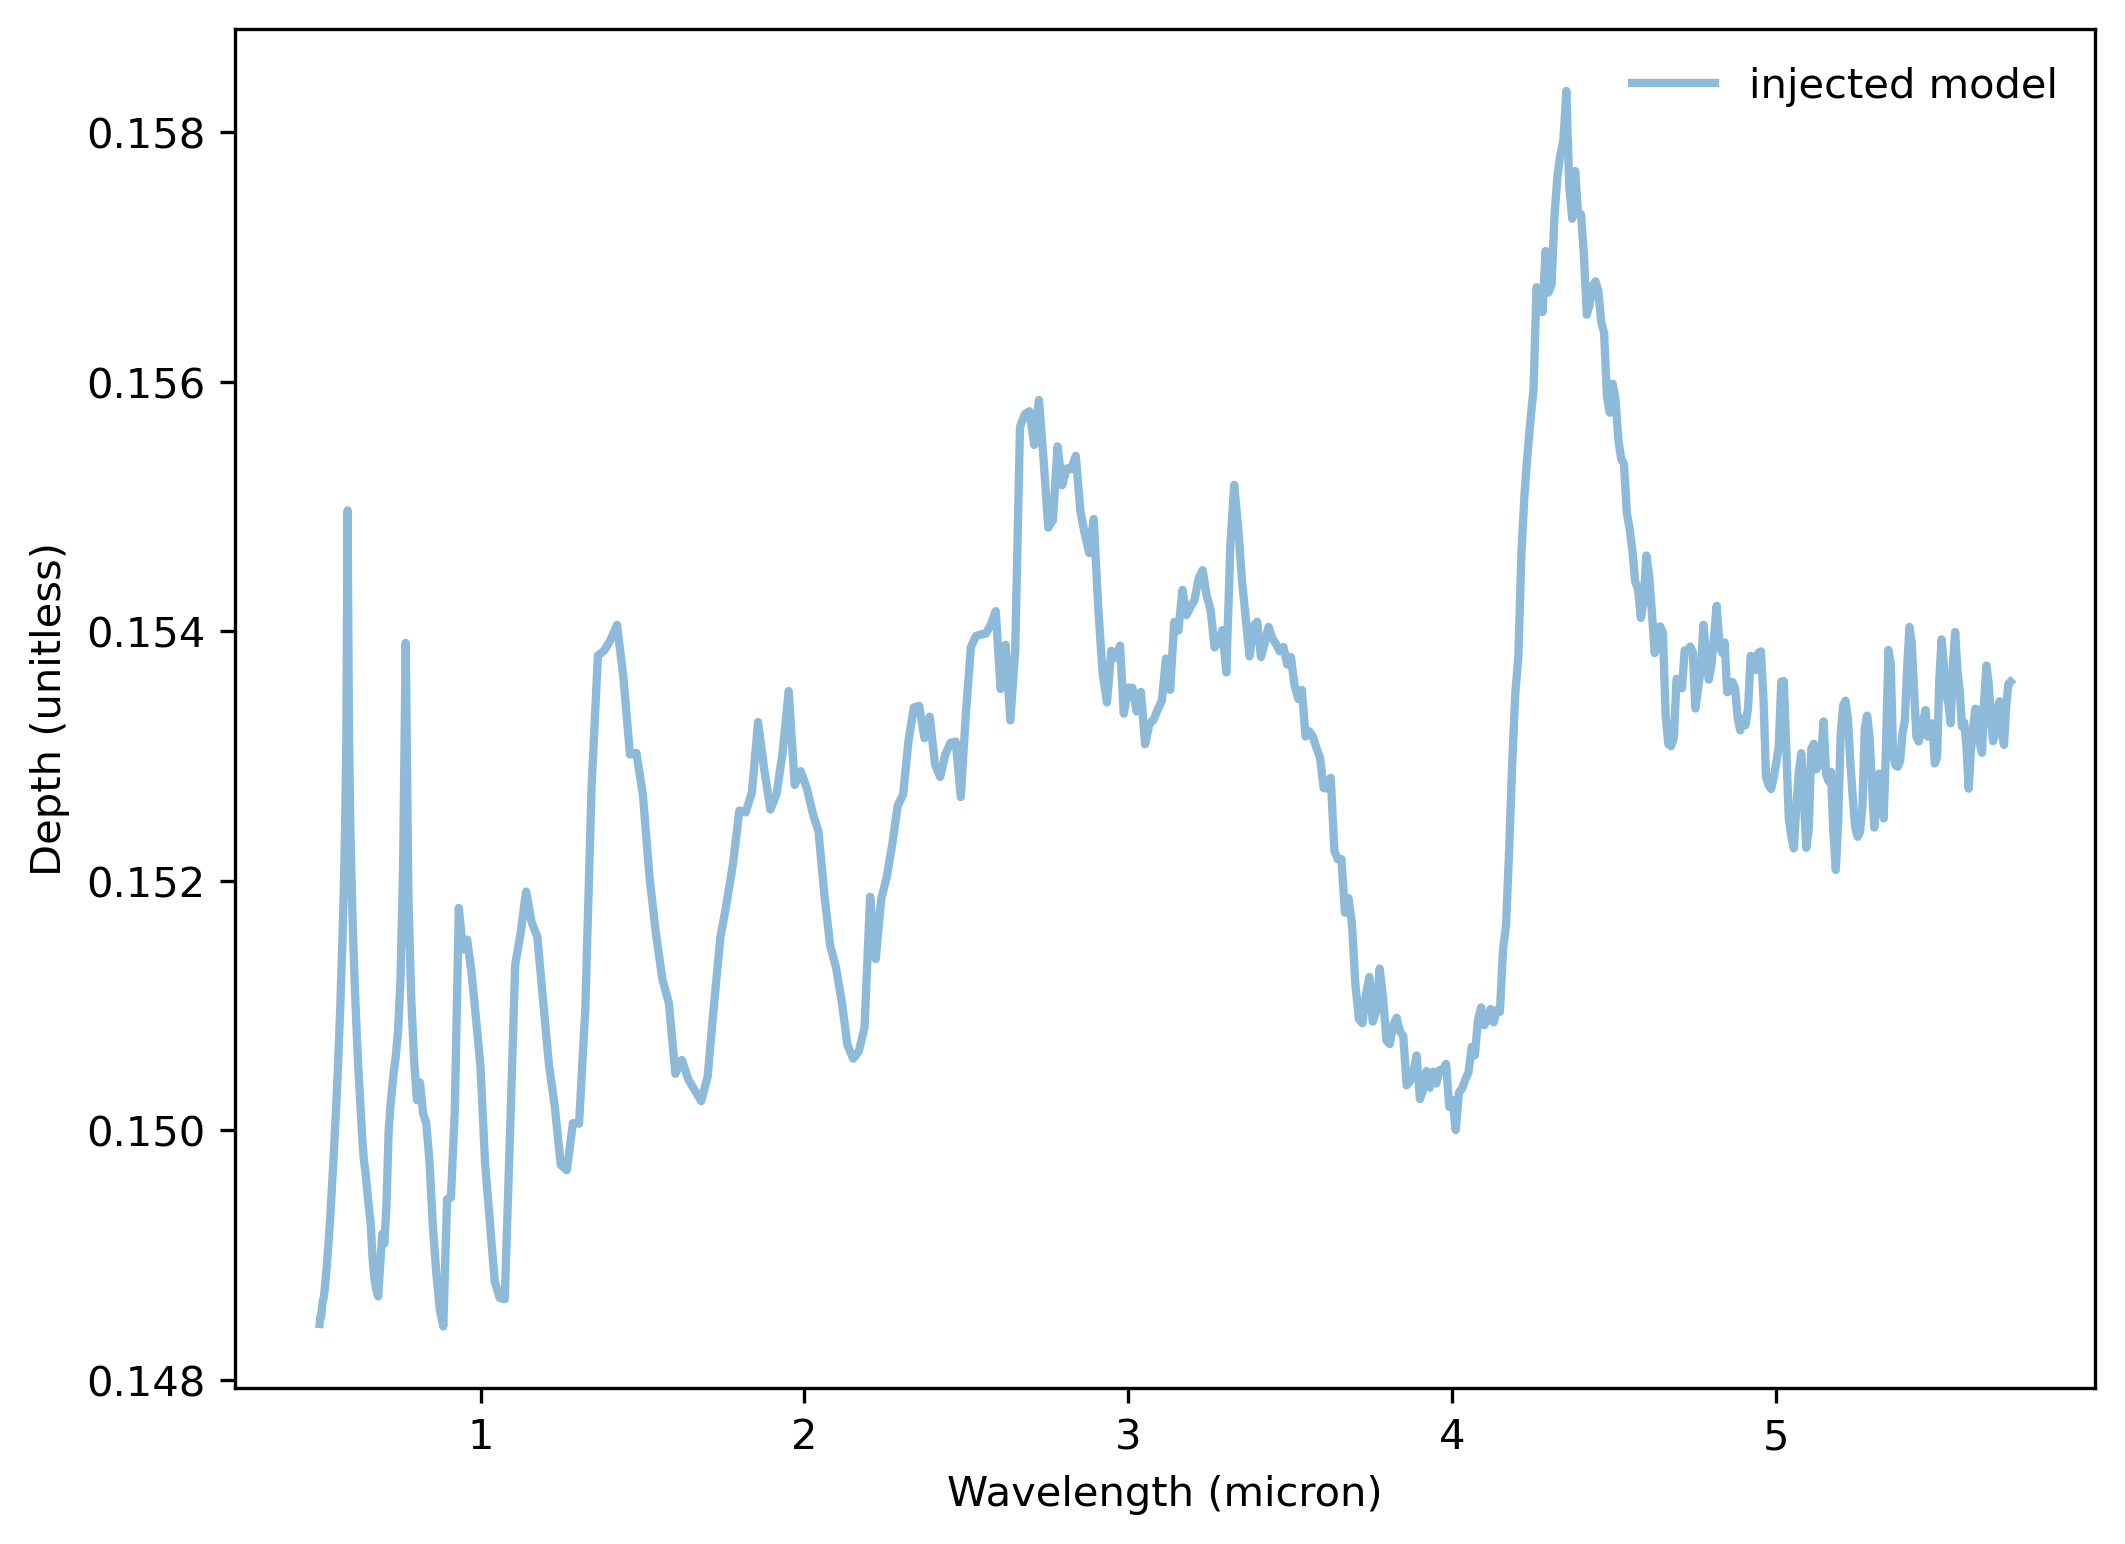

In [54]:
#  define where the zenodo LD files are stored (needed for ExoTiC)
dirsen = '/Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data' 
#  define some stellar parameters
star_params = {"M_H":-0.03, "Teff":5326.6, "logg":4.38933}
mode = "NIRSpec_Prism" #"NIRCam_F322W2"
ld_eqn='quadratic'
#  calculate the LD coeffs for a series of wavelengths and transit depths
model_ld = generate_spectrum_ld(wavelength, np.sqrt(transmission), star_params, planet_params, dirsen, mode=mode, ld_eqn=ld_eqn, ld_model='1D', plot_model=True)

In [70]:
# return synthetic rainbow + rainbow with injected transit
r,i = inject_spectrum(model_ld,ld_eqn=ld_eqn,snr=1000,dt=1,res=50)


🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...

🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...


<AxesSubplot:xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength ($\\mathrm{\\mu m}$)'>

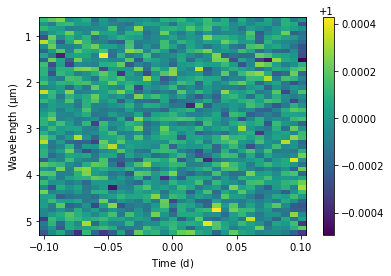

In [71]:
b_withouttransit = r.bin(
    dw=0.1*u.micron, dt=10*u.minute
)
b_withouttransit.imshow()

<AxesSubplot:xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength ($\\mathrm{\\mu m}$)'>

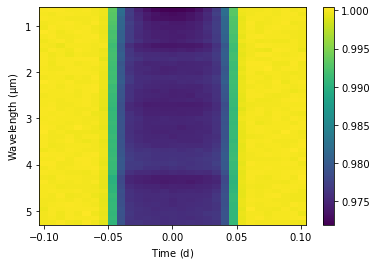

In [72]:
b_withtransit = i.bin(
    dw=0.1*u.micron, dt=10*u.minute
)
b_withtransit.imshow()


🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...

🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...

🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...


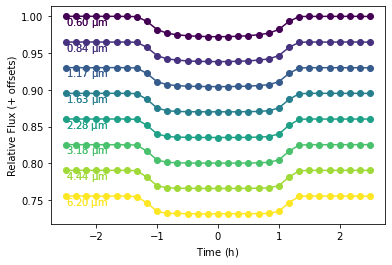

In [77]:
ax = b_withtransit.bin(R=3).plot(plotkw=dict(alpha=0.1, markeredgecolor='none', linewidth=0))
b_withtransit.bin(R=3, dt=10*u.minute).plot(ax=ax)

In [78]:
flux, flux_error, time, wavelength = rainbow_to_vector(b_withtransit)
# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(time.to_value(), wavelength.to_value())
z = flux
x = x[~np.isnan(z)]
y = y[~np.isnan(z)]
z = z[~np.isnan(z)]

In [79]:
alt_imshow(x,y,z,xlabel='Time (h)',ylabel='Wavelength (microns)',zlabel='Flux',ylog=False).display()

alt.HConcatChart(...)

# Testing out starry

In [73]:
star = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=1.0, r=1.0, prot=1.0)
star.map[1] = 0.40
star.map[2] = 0.26

Compiling `render_ld`... Done.


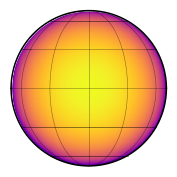

In [74]:
star.map.show()

In [75]:
planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=0,  # mass in solar masses
    r=0.1,  # radius in solar radii
    porb=1.0,  # orbital period in days
    prot=1.0,  # rotation period in days (synchronous)
    Omega=30,  # longitude of ascending node in degrees
    ecc=0.3,  # eccentricity
    w=30,  # longitude of pericenter in degrees
    t0=0,  # time of transit in days
)

Pre-computing some matrices... Done.


In [76]:
np.random.seed(123)
planet.map[1:, :] = 0.01 * np.random.randn(planet.map.Ny - 1)

Compiling `render`... Done.


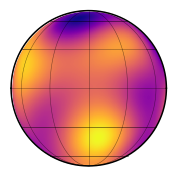

In [12]:
planet.map.show()

In [77]:
planet.theta0 = 180

In [19]:
# This routine performs gradient descent to try to find the global minimum of the map, and returns
# the latitude, longitude, and value of the intensity at the minimum.
planet.map.minimize()

ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_juyqzqby
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_5hj3s427
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_1gvmo5i9
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_762uh7jx
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_q7_4p7km
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_zc67uxlb
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_wml06b0t
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_5fz_jesf
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_75u51e8s
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_dm8qq3gc
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_qzgtmh_n
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_sqbwrt9x
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_mgwztuos
library imit=] is not found.

You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_5v0o19fq
library imit=] is not found.


Exception: ('The following error happened while compiling the node', for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25}), '\n', 'Compilation failed (return status=1): In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:25:. In file included from /usr/local/include/stdio.h:64:. /usr/local/include/_stdio.h:93:16: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         unsigned char   *_base;.                         ^. /usr/local/include/_stdio.h:93:16: note: insert \'_Nullable\' if the pointer may be null.         unsigned char   *_base;.                         ^.                           _Nullable . /usr/local/include/_stdio.h:93:16: note: insert \'_Nonnull\' if the pointer should never be null.         unsigned char   *_base;.                         ^.                           _Nonnull . /usr/local/include/_stdio.h:138:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _read) (void *, char *, int);.                                           ^. /usr/local/include/_stdio.h:138:32: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _read) (void *, char *, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:138:32: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _read) (void *, char *, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:138:40: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _read) (void *, char *, int);.                                                   ^. /usr/local/include/_stdio.h:138:40: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _read) (void *, char *, int);.                                                   ^.                                                    _Nullable. /usr/local/include/_stdio.h:138:40: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _read) (void *, char *, int);.                                                   ^.                                                    _Nonnull. /usr/local/include/_stdio.h:139:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^. /usr/local/include/_stdio.h:139:35: note: insert \'_Nullable\' if the pointer may be null.         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:139:35: note: insert \'_Nonnull\' if the pointer should never be null.         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:140:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _write)(void *, const char *, int);.                                           ^. /usr/local/include/_stdio.h:140:32: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _write)(void *, const char *, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:140:32: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _write)(void *, const char *, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:140:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^. /usr/local/include/_stdio.h:140:46: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^.                                                          _Nullable. /usr/local/include/_stdio.h:140:46: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^.                                                          _Nonnull. /usr/local/include/_stdio.h:144:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^. /usr/local/include/_stdio.h:144:18: note: insert \'_Nullable\' if the pointer may be null.         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^.                           _Nullable . /usr/local/include/_stdio.h:144:18: note: insert \'_Nonnull\' if the pointer should never be null.         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^.                           _Nonnull . In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:25:. /usr/local/include/stdio.h:67:13: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern FILE *__stdinp;.             ^. /usr/local/include/stdio.h:67:13: note: insert \'_Nullable\' if the pointer may be null. extern FILE *__stdinp;.             ^.               _Nullable . /usr/local/include/stdio.h:67:13: note: insert \'_Nonnull\' if the pointer should never be null. extern FILE *__stdinp;.             ^.               _Nonnull . /usr/local/include/stdio.h:386:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *, const char *, int),.                                         ^. /usr/local/include/stdio.h:386:41: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *, const char *, int),.                                         ^.                                          _Nullable. /usr/local/include/stdio.h:386:41: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *, const char *, int),.                                         ^.                                          _Nonnull. /usr/local/include/stdio.h:386:55: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *, const char *, int),.                                                       ^. /usr/local/include/stdio.h:386:55: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *, const char *, int),.                                                       ^.                                                        _Nullable. /usr/local/include/stdio.h:386:55: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *, const char *, int),.                                                       ^.                                                        _Nonnull. /usr/local/include/stdio.h:387:44: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^. /usr/local/include/stdio.h:387:44: note: insert \'_Nullable\' if the pointer may be null.                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^.                                             _Nullable. /usr/local/include/stdio.h:387:44: note: insert \'_Nonnull\' if the pointer should never be null.                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^.                                             _Nonnull. /usr/local/include/stdio.h:388:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *));.                                         ^. /usr/local/include/stdio.h:388:41: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *));.                                         ^.                                          _Nullable. /usr/local/include/stdio.h:388:41: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *));.                                         ^.                                          _Nonnull. /usr/local/include/stdio.h:384:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. FILE    *funopen(const void *,.         ^. /usr/local/include/stdio.h:384:6: note: insert \'_Nullable\' if the pointer may be null. FILE    *funopen(const void *,.         ^.           _Nullable . /usr/local/include/stdio.h:384:6: note: insert \'_Nonnull\' if the pointer should never be null. FILE    *funopen(const void *,.         ^.           _Nonnull . In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:34:. /usr/local/include/stdlib.h:134:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   atof(const char *);.                          ^. /usr/local/include/stdlib.h:134:25: note: insert \'_Nullable\' if the pointer may be null. double   atof(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:134:25: note: insert \'_Nonnull\' if the pointer should never be null. double   atof(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:135:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      atoi(const char *);.                          ^. /usr/local/include/stdlib.h:135:22: note: insert \'_Nullable\' if the pointer may be null. int      atoi(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:135:22: note: insert \'_Nonnull\' if the pointer should never be null. int      atoi(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:136:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     atol(const char *);.                          ^. /usr/local/include/stdlib.h:136:23: note: insert \'_Nullable\' if the pointer may be null. long     atol(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:136:23: note: insert \'_Nonnull\' if the pointer should never be null. long     atol(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:139:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          atoll(const char *);.                           ^. /usr/local/include/stdlib.h:139:20: note: insert \'_Nullable\' if the pointer may be null.          atoll(const char *);.                           ^.                            _Nullable. /usr/local/include/stdlib.h:139:20: note: insert \'_Nonnull\' if the pointer should never be null.          atoll(const char *);.                           ^.                            _Nonnull. /usr/local/include/stdlib.h:141:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^. /usr/local/include/stdlib.h:141:26: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^.                               _Nullable . /usr/local/include/stdlib.h:141:26: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:141:45: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^. /usr/local/include/stdlib.h:141:45: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^.                                                  _Nullable . /usr/local/include/stdlib.h:141:45: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^.                                                  _Nonnull . /usr/local/include/stdlib.h:142:59: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^. /usr/local/include/stdlib.h:142:59: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^.                                                                   _Nullable. /usr/local/include/stdlib.h:142:59: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^.                                                                   _Nonnull. /usr/local/include/stdlib.h:142:73: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^. /usr/local/include/stdlib.h:142:73: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^.                                                                                 _Nullable. /usr/local/include/stdlib.h:142:73: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^.                                                                                 _Nonnull. /usr/local/include/stdlib.h:141:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^. /usr/local/include/stdlib.h:141:6: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^.           _Nullable . /usr/local/include/stdlib.h:141:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^.           _Nonnull . /usr/local/include/stdlib.h:147:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getenv(const char *);.                            ^. /usr/local/include/stdlib.h:147:25: note: insert \'_Nullable\' if the pointer may be null. char    *getenv(const char *);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:147:25: note: insert \'_Nonnull\' if the pointer should never be null. char    *getenv(const char *);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:147:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getenv(const char *);.         ^. /usr/local/include/stdlib.h:147:6: note: insert \'_Nullable\' if the pointer may be null. char    *getenv(const char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:147:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *getenv(const char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:156:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mblen(const char *__s, size_t __n);.                           ^. /usr/local/include/stdlib.h:156:23: note: insert \'_Nullable\' if the pointer may be null. int      mblen(const char *__s, size_t __n);.                           ^.                             _Nullable . /usr/local/include/stdlib.h:156:23: note: insert \'_Nonnull\' if the pointer should never be null. int      mblen(const char *__s, size_t __n);.                           ^.                             _Nonnull . /usr/local/include/stdlib.h:157:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^. /usr/local/include/stdlib.h:157:26: note: insert \'_Nullable\' if the pointer may be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^.                             _Nullable. /usr/local/include/stdlib.h:157:26: note: insert \'_Nonnull\' if the pointer should never be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^.                             _Nonnull. /usr/local/include/stdlib.h:157:52: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^. /usr/local/include/stdlib.h:157:52: note: insert \'_Nullable\' if the pointer may be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^.                                                       _Nullable. /usr/local/include/stdlib.h:157:52: note: insert \'_Nonnull\' if the pointer should never be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^.                                                       _Nonnull. /usr/local/include/stdlib.h:158:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^. /usr/local/include/stdlib.h:158:21: note: insert \'_Nullable\' if the pointer may be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^.                           _Nullable. /usr/local/include/stdlib.h:158:21: note: insert \'_Nonnull\' if the pointer should never be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^.                           _Nonnull. /usr/local/include/stdlib.h:158:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^. /usr/local/include/stdlib.h:158:46: note: insert \'_Nullable\' if the pointer may be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^.                                                    _Nullable. /usr/local/include/stdlib.h:158:46: note: insert \'_Nonnull\' if the pointer should never be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^.                                                    _Nonnull. /usr/local/include/stdlib.h:160:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^. /usr/local/include/stdlib.h:160:18: note: insert \'_Nullable\' if the pointer may be null. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nullable . /usr/local/include/stdlib.h:160:18: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nonnull . /usr/local/include/stdlib.h:161:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:161:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:161:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:161:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:161:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:161:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:165:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^. /usr/local/include/stdlib.h:165:27: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:165:27: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:165:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^. /usr/local/include/stdlib.h:165:35: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^.                                     _Nullable. /usr/local/include/stdlib.h:165:35: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^.                                     _Nonnull. /usr/local/include/stdlib.h:165:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^. /usr/local/include/stdlib.h:165:36: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:165:36: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:166:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^. /usr/local/include/stdlib.h:166:26: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:166:26: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:166:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^. /usr/local/include/stdlib.h:166:34: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^.                                     _Nullable. /usr/local/include/stdlib.h:166:34: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^.                                     _Nonnull. /usr/local/include/stdlib.h:166:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^. /usr/local/include/stdlib.h:166:35: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:166:35: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:167:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                            ^. /usr/local/include/stdlib.h:167:25: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                            ^.                              _Nullable . /usr/local/include/stdlib.h:167:25: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                            ^.                              _Nonnull . /usr/local/include/stdlib.h:167:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^. /usr/local/include/stdlib.h:167:38: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:167:38: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:167:39: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:167:39: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:167:39: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:169:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                             ^. /usr/local/include/stdlib.h:169:22: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                             ^.                              _Nullable. /usr/local/include/stdlib.h:169:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                             ^.                              _Nonnull. /usr/local/include/stdlib.h:169:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                                     ^. /usr/local/include/stdlib.h:169:30: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:169:30: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:169:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                                      ^. /usr/local/include/stdlib.h:169:31: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                                      ^.                                       _Nullable. /usr/local/include/stdlib.h:169:31: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                                      ^.                                       _Nonnull. /usr/local/include/stdlib.h:172:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:172:22: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:172:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:172:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:172:35: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:172:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:172:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:172:36: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:172:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:175:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:175:22: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:175:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:175:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:175:35: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:175:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:175:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:175:36: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:175:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:178:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                              ^. /usr/local/include/stdlib.h:178:23: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                              ^.                                _Nullable . /usr/local/include/stdlib.h:178:23: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                              ^.                                _Nonnull . /usr/local/include/stdlib.h:178:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:178:36: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                                           ^.                                            _Nullable. /usr/local/include/stdlib.h:178:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                                           ^.                                            _Nonnull. /usr/local/include/stdlib.h:178:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                                            ^. /usr/local/include/stdlib.h:178:37: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                                            ^.                                              _Nullable . /usr/local/include/stdlib.h:178:37: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                                            ^.                                              _Nonnull . /usr/local/include/stdlib.h:190:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^. /usr/local/include/stdlib.h:190:24: note: insert \'_Nullable\' if the pointer may be null. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:190:24: note: insert \'_Nonnull\' if the pointer should never be null. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:194:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^. /usr/local/include/stdlib.h:194:23: note: insert \'_Nullable\' if the pointer may be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^.                          _Nullable. /usr/local/include/stdlib.h:194:23: note: insert \'_Nonnull\' if the pointer should never be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^.                          _Nonnull. /usr/local/include/stdlib.h:194:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^. /usr/local/include/stdlib.h:194:51: note: insert \'_Nullable\' if the pointer may be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^.                                                      _Nullable. /usr/local/include/stdlib.h:194:51: note: insert \'_Nonnull\' if the pointer should never be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^.                                                      _Nonnull. /usr/local/include/stdlib.h:195:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      wctomb(char *, wchar_t);.                      ^. /usr/local/include/stdlib.h:195:18: note: insert \'_Nullable\' if the pointer may be null. int      wctomb(char *, wchar_t);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:195:18: note: insert \'_Nonnull\' if the pointer should never be null. int      wctomb(char *, wchar_t);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:199:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     a64l(const char *);.                          ^. /usr/local/include/stdlib.h:199:23: note: insert \'_Nullable\' if the pointer may be null. long     a64l(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:199:23: note: insert \'_Nonnull\' if the pointer should never be null. long     a64l(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:201:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^. /usr/local/include/stdlib.h:201:29: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:201:29: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:201:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^. /usr/local/include/stdlib.h:201:46: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nullable . /usr/local/include/stdlib.h:201:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nonnull . /usr/local/include/stdlib.h:201:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^. /usr/local/include/stdlib.h:201:6: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:201:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:202:31: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. double   erand48(unsigned short[3]);.                                ^. /usr/local/include/stdlib.h:202:31: note: insert \'_Nullable\' if the array parameter may be null. double   erand48(unsigned short[3]);.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:202:31: note: insert \'_Nonnull\' if the array parameter should never be null. double   erand48(unsigned short[3]);.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:203:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^. /usr/local/include/stdlib.h:203:29: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:203:29: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:203:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^. /usr/local/include/stdlib.h:203:46: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nullable . /usr/local/include/stdlib.h:203:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nonnull . /usr/local/include/stdlib.h:203:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^. /usr/local/include/stdlib.h:203:6: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:203:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:204:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^. /usr/local/include/stdlib.h:204:30: note: insert \'_Nullable\' if the pointer may be null. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:204:30: note: insert \'_Nonnull\' if the pointer should never be null. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:204:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *gcvt(double, int, char *); /* LEGACY */.         ^. /usr/local/include/stdlib.h:204:6: note: insert \'_Nullable\' if the pointer may be null. char    *gcvt(double, int, char *); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:204:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *gcvt(double, int, char *); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:205:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                         ^. /usr/local/include/stdlib.h:205:21: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:205:21: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:205:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                          ^. /usr/local/include/stdlib.h:205:22: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:205:22: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:205:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                  ^. /usr/local/include/stdlib.h:205:30: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                  ^.                                    _Nullable. /usr/local/include/stdlib.h:205:30: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                  ^.                                    _Nonnull. /usr/local/include/stdlib.h:205:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                          ^. /usr/local/include/stdlib.h:205:38: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:205:38: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:205:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                                  ^. /usr/local/include/stdlib.h:205:46: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:205:46: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:205:47: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                                   ^. /usr/local/include/stdlib.h:205:47: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                                   ^.                                                    _Nullable. /usr/local/include/stdlib.h:205:47: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                                   ^.                                                    _Nonnull. /usr/local/include/stdlib.h:208:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^. /usr/local/include/stdlib.h:208:32: note: insert \'_Nullable\' if the pointer may be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^.                                    _Nullable. /usr/local/include/stdlib.h:208:32: note: insert \'_Nonnull\' if the pointer should never be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^.                                    _Nonnull. /usr/local/include/stdlib.h:208:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^. /usr/local/include/stdlib.h:208:6: note: insert \'_Nullable\' if the pointer may be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^.           _Nullable . /usr/local/include/stdlib.h:208:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^.           _Nonnull . /usr/local/include/stdlib.h:212:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^. /usr/local/include/stdlib.h:212:29: note: insert \'_Nullable\' if the array parameter may be null. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:212:29: note: insert \'_Nonnull\' if the array parameter should never be null. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:213:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *l64a(long);.         ^. /usr/local/include/stdlib.h:213:6: note: insert \'_Nullable\' if the pointer may be null. char    *l64a(long);.         ^.           _Nullable . /usr/local/include/stdlib.h:213:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *l64a(long);.         ^.           _Nonnull . /usr/local/include/stdlib.h:214:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. void     lcong48(unsigned short[7]);.                                ^. /usr/local/include/stdlib.h:214:29: note: insert \'_Nullable\' if the array parameter may be null. void     lcong48(unsigned short[7]);.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:214:29: note: insert \'_Nonnull\' if the array parameter should never be null. void     lcong48(unsigned short[7]);.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:216:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *mktemp(char *);.                      ^. /usr/local/include/stdlib.h:216:19: note: insert \'_Nullable\' if the pointer may be null. char    *mktemp(char *);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:216:19: note: insert \'_Nonnull\' if the pointer should never be null. char    *mktemp(char *);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:216:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *mktemp(char *);.         ^. /usr/local/include/stdlib.h:216:6: note: insert \'_Nullable\' if the pointer may be null. char    *mktemp(char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:216:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *mktemp(char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:217:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mkstemp(char *);.                       ^. /usr/local/include/stdlib.h:217:19: note: insert \'_Nullable\' if the pointer may be null. int      mkstemp(char *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:217:19: note: insert \'_Nonnull\' if the pointer should never be null. int      mkstemp(char *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:219:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^. /usr/local/include/stdlib.h:219:29: note: insert \'_Nullable\' if the array parameter may be null. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:219:29: note: insert \'_Nonnull\' if the array parameter should never be null. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:221:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ptsname(int);.         ^. /usr/local/include/stdlib.h:221:6: note: insert \'_Nullable\' if the pointer may be null. char    *ptsname(int);.         ^.           _Nullable . /usr/local/include/stdlib.h:221:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *ptsname(int);.         ^.           _Nonnull . /usr/local/include/stdlib.h:224:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^. /usr/local/include/stdlib.h:224:32: note: insert \'_Nullable\' if the pointer may be null. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:224:32: note: insert \'_Nonnull\' if the pointer should never be null. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:227:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^. /usr/local/include/stdlib.h:227:18: note: insert \'_Nullable\' if the pointer may be null. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:227:18: note: insert \'_Nonnull\' if the pointer should never be null. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:229:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^. /usr/local/include/stdlib.h:229:22: note: insert \'_Nullable\' if the pointer may be null. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^.                           _Nullable. /usr/local/include/stdlib.h:229:22: note: insert \'_Nonnull\' if the pointer should never be null. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:231:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^. /usr/local/include/stdlib.h:231:27: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^.                                _Nullable. /usr/local/include/stdlib.h:231:27: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^.                                _Nonnull. /usr/local/include/stdlib.h:231:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^. /usr/local/include/stdlib.h:231:46: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^.                                                   _Nullable. /usr/local/include/stdlib.h:231:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^.                                                   _Nonnull. /usr/local/include/stdlib.h:231:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^. /usr/local/include/stdlib.h:231:6: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^.           _Nullable . /usr/local/include/stdlib.h:231:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^.           _Nonnull . /usr/local/include/stdlib.h:236:24: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays].         *seed48(unsigned short[3]);.                               ^. /usr/local/include/stdlib.h:236:24: note: insert \'_Nullable\' if the array parameter may be null.         *seed48(unsigned short[3]);.                               ^.                                _Nullable . /usr/local/include/stdlib.h:236:24: note: insert \'_Nonnull\' if the array parameter should never be null.         *seed48(unsigned short[3]);.                               ^.                                _Nonnull . /usr/local/include/stdlib.h:236:2: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         *seed48(unsigned short[3]);.         ^. /usr/local/include/stdlib.h:236:2: note: insert \'_Nullable\' if the pointer may be null.         *seed48(unsigned short[3]);.         ^.           _Nullable . /usr/local/include/stdlib.h:236:2: note: insert \'_Nonnull\' if the pointer should never be null.         *seed48(unsigned short[3]);.         ^.           _Nonnull . /usr/local/include/stdlib.h:237:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^. /usr/local/include/stdlib.h:237:24: note: insert \'_Nullable\' if the pointer may be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^.                              _Nullable. /usr/local/include/stdlib.h:237:24: note: insert \'_Nonnull\' if the pointer should never be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^.                              _Nonnull. /usr/local/include/stdlib.h:237:45: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^. /usr/local/include/stdlib.h:237:45: note: insert \'_Nullable\' if the pointer may be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^.                                                   _Nullable. /usr/local/include/stdlib.h:237:45: note: insert \'_Nonnull\' if the pointer should never be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^.                                                   _Nonnull. /usr/local/include/stdlib.h:239:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^. /usr/local/include/stdlib.h:239:25: note: insert \'_Nullable\' if the pointer may be null. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:239:25: note: insert \'_Nonnull\' if the pointer should never be null. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:243:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *setstate(const char *);.                              ^. /usr/local/include/stdlib.h:243:27: note: insert \'_Nullable\' if the pointer may be null. char    *setstate(const char *);.                              ^.                               _Nullable. /usr/local/include/stdlib.h:243:27: note: insert \'_Nonnull\' if the pointer should never be null. char    *setstate(const char *);.                              ^.                               _Nonnull. /usr/local/include/stdlib.h:243:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *setstate(const char *);.         ^. /usr/local/include/stdlib.h:243:6: note: insert \'_Nullable\' if the pointer may be null. char    *setstate(const char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:243:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *setstate(const char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:252:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^. /usr/local/include/stdlib.h:252:26: note: insert \'_Nullable\' if the pointer may be null. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^.                               _Nullable. /usr/local/include/stdlib.h:252:26: note: insert \'_Nonnull\' if the pointer should never be null. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^.                               _Nonnull. /usr/local/include/stdlib.h:265:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^. /usr/local/include/stdlib.h:265:42: note: insert \'_Nullable\' if the pointer may be null. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^.                                               _Nullable. /usr/local/include/stdlib.h:265:42: note: insert \'_Nonnull\' if the pointer should never be null. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^.                                               _Nonnull. /usr/local/include/stdlib.h:270:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^. /usr/local/include/stdlib.h:270:27: note: insert \'_Nullable\' if the pointer may be null. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^.                                _Nullable. /usr/local/include/stdlib.h:270:27: note: insert \'_Nonnull\' if the pointer should never be null. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^.                                _Nonnull. /usr/local/include/stdlib.h:276:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^. /usr/local/include/stdlib.h:276:28: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^.                                 _Nullable . /usr/local/include/stdlib.h:276:28: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^.                                 _Nonnull . /usr/local/include/stdlib.h:276:47: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^. /usr/local/include/stdlib.h:276:47: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^.                                                    _Nullable . /usr/local/include/stdlib.h:276:47: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^.                                                    _Nonnull . /usr/local/include/stdlib.h:277:59: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^. /usr/local/include/stdlib.h:277:59: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^.                                                                   _Nullable. /usr/local/include/stdlib.h:277:59: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^.                                                                   _Nonnull. /usr/local/include/stdlib.h:277:73: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^. /usr/local/include/stdlib.h:277:73: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^.                                                                                 _Nullable. /usr/local/include/stdlib.h:277:73: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^.                                                                                 _Nonnull. /usr/local/include/stdlib.h:276:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^. /usr/local/include/stdlib.h:276:6: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^.           _Nullable . /usr/local/include/stdlib.h:276:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^.           _Nonnull . /usr/local/include/stdlib.h:281:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.                       ^. /usr/local/include/stdlib.h:281:20: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:281:20: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:281:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.                                     ^. /usr/local/include/stdlib.h:281:34: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:281:34: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:281:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.         ^. /usr/local/include/stdlib.h:281:6: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.         ^.           _Nullable . /usr/local/include/stdlib.h:281:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.         ^.           _Nonnull . /usr/local/include/stdlib.h:283:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                       ^. /usr/local/include/stdlib.h:283:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:283:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:283:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                        ^. /usr/local/include/stdlib.h:283:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:283:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:283:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                ^. /usr/local/include/stdlib.h:283:28: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                ^.                                 _Nullable. /usr/local/include/stdlib.h:283:28: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                ^.                                 _Nonnull. /usr/local/include/stdlib.h:283:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                 ^. /usr/local/include/stdlib.h:283:29: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:283:29: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:283:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                               ^. /usr/local/include/stdlib.h:283:43: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                               ^.                                                _Nullable. /usr/local/include/stdlib.h:283:43: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                               ^.                                                _Nonnull. /usr/local/include/stdlib.h:284:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                         ^. /usr/local/include/stdlib.h:284:21: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:284:21: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:284:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                          ^. /usr/local/include/stdlib.h:284:22: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:284:22: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:284:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                                  ^. /usr/local/include/stdlib.h:284:30: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                                  ^.                                   _Nullable. /usr/local/include/stdlib.h:284:30: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                                  ^.                                   _Nonnull. /usr/local/include/stdlib.h:284:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                                   ^. /usr/local/include/stdlib.h:284:31: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                                   ^.                                    _Nullable. /usr/local/include/stdlib.h:284:31: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                                   ^.                                    _Nonnull. /usr/local/include/stdlib.h:285:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetmatch(const char *, const char *);.                               ^. /usr/local/include/stdlib.h:285:27: note: insert \'_Nullable\' if the pointer may be null. int      cgetmatch(const char *, const char *);.                               ^.                                _Nullable. /usr/local/include/stdlib.h:285:27: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetmatch(const char *, const char *);.                               ^.                                _Nonnull. /usr/local/include/stdlib.h:285:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetmatch(const char *, const char *);.                                             ^. /usr/local/include/stdlib.h:285:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetmatch(const char *, const char *);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:285:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetmatch(const char *, const char *);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:286:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                        ^. /usr/local/include/stdlib.h:286:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:286:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:286:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                         ^. /usr/local/include/stdlib.h:286:21: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:286:21: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:286:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                                 ^. /usr/local/include/stdlib.h:286:29: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:286:29: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:286:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                                  ^. /usr/local/include/stdlib.h:286:30: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                                  ^.                                   _Nullable. /usr/local/include/stdlib.h:286:30: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                                  ^.                                   _Nonnull. /usr/local/include/stdlib.h:287:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                       ^. /usr/local/include/stdlib.h:287:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:287:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:287:33: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                                     ^. /usr/local/include/stdlib.h:287:33: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:287:33: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:287:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                                             ^. /usr/local/include/stdlib.h:287:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:287:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:288:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetset(const char *);.                             ^. /usr/local/include/stdlib.h:288:25: note: insert \'_Nullable\' if the pointer may be null. int      cgetset(const char *);.                             ^.                              _Nullable. /usr/local/include/stdlib.h:288:25: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetset(const char *);.                             ^.                              _Nonnull. /usr/local/include/stdlib.h:289:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                       ^. /usr/local/include/stdlib.h:289:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:289:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:289:33: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                     ^. /usr/local/include/stdlib.h:289:33: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:289:33: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:289:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                             ^. /usr/local/include/stdlib.h:289:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:289:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:289:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                              ^. /usr/local/include/stdlib.h:289:42: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                              ^.                                               _Nullable. /usr/local/include/stdlib.h:289:42: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                              ^.                                               _Nonnull. /usr/local/include/stdlib.h:290:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                        ^. /usr/local/include/stdlib.h:290:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:290:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:290:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                      ^. /usr/local/include/stdlib.h:290:34: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                      ^.                                       _Nullable. /usr/local/include/stdlib.h:290:34: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                      ^.                                       _Nonnull. /usr/local/include/stdlib.h:290:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                              ^. /usr/local/include/stdlib.h:290:42: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                              ^.                                               _Nullable. /usr/local/include/stdlib.h:290:42: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                              ^.                                               _Nonnull. /usr/local/include/stdlib.h:290:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                               ^. /usr/local/include/stdlib.h:290:43: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                               ^.                                                _Nullable. /usr/local/include/stdlib.h:290:43: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                               ^.                                                _Nonnull. /usr/local/include/stdlib.h:293:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname(dev_t, mode_t);.         ^. /usr/local/include/stdlib.h:293:6: note: insert \'_Nullable\' if the pointer may be null. char    *devname(dev_t, mode_t);.         ^.           _Nullable . /usr/local/include/stdlib.h:293:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname(dev_t, mode_t);.         ^.           _Nonnull . /usr/local/include/stdlib.h:294:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^. /usr/local/include/stdlib.h:294:37: note: insert \'_Nullable\' if the pointer may be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^.                                          _Nullable . /usr/local/include/stdlib.h:294:37: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^.                                          _Nonnull . /usr/local/include/stdlib.h:294:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^. /usr/local/include/stdlib.h:294:6: note: insert \'_Nullable\' if the pointer may be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^.           _Nullable . /usr/local/include/stdlib.h:294:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^.           _Nonnull . /usr/local/include/stdlib.h:295:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.                       ^. /usr/local/include/stdlib.h:295:20: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:295:20: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:295:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.                               ^. /usr/local/include/stdlib.h:295:28: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.                               ^.                                _Nullable. /usr/local/include/stdlib.h:295:28: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.                               ^.                                _Nonnull. /usr/local/include/stdlib.h:295:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.         ^. /usr/local/include/stdlib.h:295:6: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.         ^.           _Nullable . /usr/local/include/stdlib.h:295:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:296:24: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. int      getloadavg(double [], int);.                            ^. /usr/local/include/stdlib.h:296:24: note: insert \'_Nullable\' if the array parameter may be null. int      getloadavg(double [], int);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:296:24: note: insert \'_Nonnull\' if the array parameter should never be null. int      getloadavg(double [], int);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:298:2: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         *getprogname(void);.         ^. /usr/local/include/stdlib.h:298:2: note: insert \'_Nullable\' if the pointer may be null.         *getprogname(void);.         ^.           _Nullable . /usr/local/include/stdlib.h:298:2: note: insert \'_Nonnull\' if the pointer should never be null.         *getprogname(void);.         ^.           _Nonnull . /usr/local/include/stdlib.h:299:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     setprogname(const char *);.                                 ^. /usr/local/include/stdlib.h:299:30: note: insert \'_Nullable\' if the pointer may be null. void     setprogname(const char *);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:299:30: note: insert \'_Nonnull\' if the pointer should never be null. void     setprogname(const char *);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:309:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^. /usr/local/include/stdlib.h:309:20: note: insert \'_Nullable\' if the pointer may be null. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^.                          _Nullable . /usr/local/include/stdlib.h:309:20: note: insert \'_Nonnull\' if the pointer should never be null. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^.                          _Nonnull . /usr/local/include/stdlib.h:310:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:310:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:310:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:310:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:310:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:310:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:312:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^. /usr/local/include/stdlib.h:312:22: note: insert \'_Nullable\' if the pointer may be null. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^.                            _Nullable . /usr/local/include/stdlib.h:312:22: note: insert \'_Nonnull\' if the pointer should never be null. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^.                            _Nonnull . /usr/local/include/stdlib.h:313:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:313:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:313:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:313:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:313:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:313:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:316:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^. /usr/local/include/stdlib.h:316:21: note: insert \'_Nullable\' if the pointer may be null. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^.                           _Nullable . /usr/local/include/stdlib.h:316:21: note: insert \'_Nonnull\' if the pointer should never be null. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^.                           _Nonnull . /usr/local/include/stdlib.h:317:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:317:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:317:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:317:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:317:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:317:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:319:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^. /usr/local/include/stdlib.h:319:23: note: insert \'_Nullable\' if the pointer may be null. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^.                             _Nullable . /usr/local/include/stdlib.h:319:23: note: insert \'_Nonnull\' if the pointer should never be null. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^.                             _Nonnull . /usr/local/include/stdlib.h:320:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:320:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:320:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:320:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:320:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:320:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:323:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort(void *__base, size_t __nel, size_t __width,.                     ^. /usr/local/include/stdlib.h:323:18: note: insert \'_Nullable\' if the pointer may be null. void     psort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nullable . /usr/local/include/stdlib.h:323:18: note: insert \'_Nonnull\' if the pointer should never be null. void     psort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nonnull . /usr/local/include/stdlib.h:324:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^. /usr/local/include/stdlib.h:324:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:324:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:324:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^. /usr/local/include/stdlib.h:324:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:324:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:327:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^. /usr/local/include/stdlib.h:327:20: note: insert \'_Nullable\' if the pointer may be null. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:327:20: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:328:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:328:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:328:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:328:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:328:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:328:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:331:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^. /usr/local/include/stdlib.h:331:20: note: insert \'_Nullable\' if the pointer may be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:331:20: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:331:64: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^. /usr/local/include/stdlib.h:331:64: note: insert \'_Nullable\' if the pointer may be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nullable. /usr/local/include/stdlib.h:331:64: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nonnull. /usr/local/include/stdlib.h:332:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^. /usr/local/include/stdlib.h:332:37: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^.                                             _Nullable. /usr/local/include/stdlib.h:332:37: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^.                                             _Nonnull. /usr/local/include/stdlib.h:332:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^. /usr/local/include/stdlib.h:332:51: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^.                                                           _Nullable. /usr/local/include/stdlib.h:332:51: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^.                                                           _Nonnull. /usr/local/include/stdlib.h:332:65: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^. /usr/local/include/stdlib.h:332:65: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^.                                                                         _Nullable. /usr/local/include/stdlib.h:332:65: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^.                                                                         _Nonnull. /usr/local/include/stdlib.h:335:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^. /usr/local/include/stdlib.h:335:20: note: insert \'_Nullable\' if the pointer may be null. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:335:20: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:336:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:336:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:336:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:336:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:336:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:336:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:339:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^. /usr/local/include/stdlib.h:339:20: note: insert \'_Nullable\' if the pointer may be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:339:20: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:339:64: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^. /usr/local/include/stdlib.h:339:64: note: insert \'_Nullable\' if the pointer may be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nullable. /usr/local/include/stdlib.h:339:64: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nonnull. /usr/local/include/stdlib.h:340:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^. /usr/local/include/stdlib.h:340:37: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^.                                             _Nullable. /usr/local/include/stdlib.h:340:37: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^.                                             _Nonnull. /usr/local/include/stdlib.h:340:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^. /usr/local/include/stdlib.h:340:51: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^.                                                           _Nullable. /usr/local/include/stdlib.h:340:51: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^.                                                           _Nonnull. /usr/local/include/stdlib.h:340:65: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^. /usr/local/include/stdlib.h:340:65: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^.                                                                         _Nullable. /usr/local/include/stdlib.h:340:65: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^.                                                                         _Nonnull. /usr/local/include/stdlib.h:341:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^. /usr/local/include/stdlib.h:341:36: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^.                                         _Nullable. /usr/local/include/stdlib.h:341:36: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^.                                         _Nonnull. /usr/local/include/stdlib.h:341:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^. /usr/local/include/stdlib.h:341:37: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                           _Nullable . /usr/local/include/stdlib.h:341:37: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                           _Nonnull . /usr/local/include/stdlib.h:341:77: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^. /usr/local/include/stdlib.h:341:77: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^.                                                                                   _Nullable . /usr/local/include/stdlib.h:341:77: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^.                                                                                   _Nonnull . /usr/local/include/stdlib.h:343:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     rpmatch(const char *).                            ^. /usr/local/include/stdlib.h:343:24: note: insert \'_Nullable\' if the pointer may be null. int     rpmatch(const char *).                            ^.                             _Nullable. /usr/local/include/stdlib.h:343:24: note: insert \'_Nonnull\' if the pointer should never be null. int     rpmatch(const char *).                            ^.                             _Nonnull. /usr/local/include/stdlib.h:345:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^. /usr/local/include/stdlib.h:345:37: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:345:37: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:345:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^. /usr/local/include/stdlib.h:345:38: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:345:38: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:345:78: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^. /usr/local/include/stdlib.h:345:78: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^.                                                                                    _Nullable . /usr/local/include/stdlib.h:345:78: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^.                                                                                    _Nonnull . /usr/local/include/stdlib.h:349:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^. /usr/local/include/stdlib.h:349:21: note: insert \'_Nullable\' if the pointer may be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^.                          _Nullable . /usr/local/include/stdlib.h:349:21: note: insert \'_Nonnull\' if the pointer should never be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^.                          _Nonnull . /usr/local/include/stdlib.h:349:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^. /usr/local/include/stdlib.h:349:6: note: insert \'_Nullable\' if the pointer may be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^.           _Nullable . /usr/local/include/stdlib.h:349:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^.           _Nonnull . /usr/local/include/stdlib.h:351:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^. /usr/local/include/stdlib.h:351:22: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^.                               _Nullable . /usr/local/include/stdlib.h:351:22: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^.                               _Nonnull . /usr/local/include/stdlib.h:351:84: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^. /usr/local/include/stdlib.h:351:84: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^.                                                                                            _Nullable. /usr/local/include/stdlib.h:351:84: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^.                                                                                            _Nonnull. /usr/local/include/stdlib.h:351:85: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^. /usr/local/include/stdlib.h:351:85: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^.                                                                                              _Nullable . /usr/local/include/stdlib.h:351:85: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^.                                                                                              _Nonnull . /usr/local/include/stdlib.h:355:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                            ^. /usr/local/include/stdlib.h:355:21: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                            ^.                              _Nullable . /usr/local/include/stdlib.h:355:21: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                            ^.                              _Nonnull . /usr/local/include/stdlib.h:355:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                                         ^. /usr/local/include/stdlib.h:355:34: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:355:34: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:355:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:355:35: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:355:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:357:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:357:22: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:357:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:357:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:357:35: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:357:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:357:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:357:36: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:357:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:359:13: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^. /usr/local/include/stdlib.h:359:13: note: insert \'_Nullable\' if the pointer may be null. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^.               _Nullable . /usr/local/include/stdlib.h:359:13: note: insert \'_Nonnull\' if the pointer should never be null. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^.               _Nonnull . In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:145:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/pythread.h:128:. /usr/local/include/pthread.h:328:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. #if !_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT.      ^. /usr/local/include/pthread.h:197:2: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).         ^. /usr/local/include/pthread.h:328:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. /usr/local/include/pthread.h:197:34: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).                                         ^. /usr/local/include/pthread.h:537:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. #if !_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT.      ^. /usr/local/include/pthread.h:197:2: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).         ^. /usr/local/include/pthread.h:537:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. /usr/local/include/pthread.h:197:34: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).                                         ^. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:610:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/numpy/core/include/numpy/npy_interrupt.h:23:. /usr/local/include/signal.h:69:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern __const char *__const sys_signame[NSIG];.                     ^. /usr/local/include/signal.h:69:21: note: insert \'_Nullable\' if the pointer may be null. extern __const char *__const sys_signame[NSIG];.                     ^.                       _Nullable . /usr/local/include/signal.h:69:21: note: insert \'_Nonnull\' if the pointer should never be null. extern __const char *__const sys_signame[NSIG];.                     ^.                       _Nonnull . /usr/local/include/signal.h:82:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_kill(pthread_t, int);.                      ^. /usr/local/include/signal.h:82:18: note: insert \'_Nullable\' if the pointer may be null. int     pthread_kill(pthread_t, int);.                      ^.                                _Nullable . /usr/local/include/signal.h:82:18: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_kill(pthread_t, int);.                      ^.                                _Nonnull . /usr/local/include/signal.h:83:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^. /usr/local/include/signal.h:83:41: note: insert \'_Nullable\' if the pointer may be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^.                                              _Nullable. /usr/local/include/signal.h:83:41: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^.                                              _Nonnull. /usr/local/include/signal.h:83:53: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^. /usr/local/include/signal.h:83:53: note: insert \'_Nullable\' if the pointer may be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^.                                                          _Nullable. /usr/local/include/signal.h:83:53: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^.                                                          _Nonnull. /usr/local/include/signal.h:84:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaction(int, const struct sigaction * __restrict,.                                               ^. /usr/local/include/signal.h:84:43: note: insert \'_Nullable\' if the pointer may be null. int     sigaction(int, const struct sigaction * __restrict,.                                               ^.                                                 _Nullable. /usr/local/include/signal.h:84:43: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaction(int, const struct sigaction * __restrict,.                                               ^.                                                 _Nonnull. /usr/local/include/signal.h:85:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             struct sigaction * __restrict);.                              ^. /usr/local/include/signal.h:85:23: note: insert \'_Nullable\' if the pointer may be null.             struct sigaction * __restrict);.                              ^.                                _Nullable. /usr/local/include/signal.h:85:23: note: insert \'_Nonnull\' if the pointer should never be null.             struct sigaction * __restrict);.                              ^.                                _Nonnull. /usr/local/include/signal.h:86:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaddset(sigset_t *, int);.                            ^. /usr/local/include/signal.h:86:24: note: insert \'_Nullable\' if the pointer may be null. int     sigaddset(sigset_t *, int);.                            ^.                             _Nullable. /usr/local/include/signal.h:86:24: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaddset(sigset_t *, int);.                            ^.                             _Nonnull. /usr/local/include/signal.h:87:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^. /usr/local/include/signal.h:87:31: note: insert \'_Nullable\' if the pointer may be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^.                                     _Nullable. /usr/local/include/signal.h:87:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^.                                     _Nonnull. /usr/local/include/signal.h:87:53: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^. /usr/local/include/signal.h:87:53: note: insert \'_Nullable\' if the pointer may be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^.                                                           _Nullable. /usr/local/include/signal.h:87:53: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^.                                                           _Nonnull. /usr/local/include/signal.h:88:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigdelset(sigset_t *, int);.                            ^. /usr/local/include/signal.h:88:24: note: insert \'_Nullable\' if the pointer may be null. int     sigdelset(sigset_t *, int);.                            ^.                             _Nullable. /usr/local/include/signal.h:88:24: note: insert \'_Nonnull\' if the pointer should never be null. int     sigdelset(sigset_t *, int);.                            ^.                             _Nonnull. /usr/local/include/signal.h:89:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigemptyset(sigset_t *);.                              ^. /usr/local/include/signal.h:89:26: note: insert \'_Nullable\' if the pointer may be null. int     sigemptyset(sigset_t *);.                              ^.                               _Nullable. /usr/local/include/signal.h:89:26: note: insert \'_Nonnull\' if the pointer should never be null. int     sigemptyset(sigset_t *);.                              ^.                               _Nonnull. /usr/local/include/signal.h:90:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigfillset(sigset_t *);.                             ^. /usr/local/include/signal.h:90:25: note: insert \'_Nullable\' if the pointer may be null. int     sigfillset(sigset_t *);.                             ^.                              _Nullable. /usr/local/include/signal.h:90:25: note: insert \'_Nonnull\' if the pointer should never be null. int     sigfillset(sigset_t *);.                             ^.                              _Nonnull. /usr/local/include/signal.h:94:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigismember(const sigset_t *, int);.                                    ^. /usr/local/include/signal.h:94:32: note: insert \'_Nullable\' if the pointer may be null. int     sigismember(const sigset_t *, int);.                                    ^.                                     _Nullable. /usr/local/include/signal.h:94:32: note: insert \'_Nonnull\' if the pointer should never be null. int     sigismember(const sigset_t *, int);.                                    ^.                                     _Nonnull. /usr/local/include/signal.h:96:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigpending(sigset_t *);.                             ^. /usr/local/include/signal.h:96:25: note: insert \'_Nullable\' if the pointer may be null. int     sigpending(sigset_t *);.                             ^.                              _Nullable. /usr/local/include/signal.h:96:25: note: insert \'_Nonnull\' if the pointer should never be null. int     sigpending(sigset_t *);.                             ^.                              _Nonnull. /usr/local/include/signal.h:97:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^. /usr/local/include/signal.h:97:37: note: insert \'_Nullable\' if the pointer may be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^.                                           _Nullable. /usr/local/include/signal.h:97:37: note: insert \'_Nonnull\' if the pointer should never be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^.                                           _Nonnull. /usr/local/include/signal.h:97:60: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^. /usr/local/include/signal.h:97:60: note: insert \'_Nullable\' if the pointer may be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^.                                                                  _Nullable. /usr/local/include/signal.h:97:60: note: insert \'_Nonnull\' if the pointer should never be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^.                                                                  _Nonnull. /usr/local/include/signal.h:100:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^. /usr/local/include/signal.h:100:31: note: insert \'_Nullable\' if the pointer may be null. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^.                                    _Nullable. /usr/local/include/signal.h:100:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^.                                    _Nonnull. /usr/local/include/signal.h:101:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^. /usr/local/include/signal.h:101:28: note: insert \'_Nullable\' if the pointer may be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^.                                  _Nullable. /usr/local/include/signal.h:101:28: note: insert \'_Nonnull\' if the pointer should never be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^.                                  _Nonnull. /usr/local/include/signal.h:101:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^. /usr/local/include/signal.h:101:46: note: insert \'_Nullable\' if the pointer may be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^.                                                    _Nullable. /usr/local/include/signal.h:101:46: note: insert \'_Nonnull\' if the pointer should never be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^.                                                    _Nonnull. /usr/local/include/signal.h:103:39: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    psignal(unsigned int, const char *);.                                          ^. /usr/local/include/signal.h:103:39: note: insert \'_Nullable\' if the pointer may be null. void    psignal(unsigned int, const char *);.                                          ^.                                           _Nullable. /usr/local/include/signal.h:103:39: note: insert \'_Nonnull\' if the pointer should never be null. void    psignal(unsigned int, const char *);.                                          ^.                                           _Nonnull. /usr/local/include/signal.h:106:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^. /usr/local/include/signal.h:106:31: note: insert \'_Nullable\' if the pointer may be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^.                                    _Nullable. /usr/local/include/signal.h:106:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^.                                    _Nonnull. /usr/local/include/signal.h:106:48: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^. /usr/local/include/signal.h:106:48: note: insert \'_Nullable\' if the pointer may be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^.                                                     _Nullable. /usr/local/include/signal.h:106:48: note: insert \'_Nonnull\' if the pointer should never be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^.                                                     _Nonnull. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:833:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:317:9: error: no member named \'signbit\' in the global namespace; did you mean \'sigwait\'?. using ::signbit;.       ~~^. /usr/local/include/signal.h:101:5: note: \'sigwait\' declared here. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.         ^. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:833:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:318:9: error: no member named \'fpclassify\' in the global namespace. using ::fpclassify;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:319:9: error: no member named \'isfinite\' in the global namespace; did you mean \'finite\'?. using ::isfinite;.       ~~^. /usr/local/include/math.h:752:12: note: \'finite\' declared here. extern int finite(double).            ^. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:833:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:320:9: error: no member named \'isinf\' in the global namespace. using ::isinf;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:321:9: error: no member named \'isnan\' in the global namespace. using ::isnan;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:322:9: error: no member named \'isnormal\' in the global namespace. using ::isnormal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:323:9: error: no member named \'isgreater\' in the global namespace. using ::isgreater;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:324:9: error: no member named \'isgreaterequal\' in the global namespace. using ::isgreaterequal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:325:9: error: no member named \'isless\' in the global namespace. using ::isless;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:326:9: error: no member named \'islessequal\' in the global namespace. using ::islessequal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:327:9: error: no member named \'islessgreater\' in the global namespace. using ::islessgreater;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:328:9: error: no member named \'isunordered\' in the global namespace. using ::isunordered;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:329:9: error: no member named \'isunordered\' in the global namespace. using ::isunordered;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:640:26: error: no template named \'numeric_limits\'.     bool _FloatBigger = (numeric_limits<_FloatT>::digits > numeric_limits<_IntT>::digits),.                          ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:640:60: error: no template named \'numeric_limits\'.     bool _FloatBigger = (numeric_limits<_FloatT>::digits > numeric_limits<_IntT>::digits),.                                                            ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:641:18: error: no template named \'numeric_limits\'.     int _Bits = (numeric_limits<_IntT>::digits - numeric_limits<_FloatT>::digits)>.                  ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:641:50: error: no template named \'numeric_limits\'.     int _Bits = (numeric_limits<_IntT>::digits - numeric_limits<_FloatT>::digits)>.                                                  ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:646:17: error: no template named \'numeric_limits\'.   static_assert(numeric_limits<_FloatT>::radix == 2, "FloatT has incorrect radix");.                 ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:649:25: error: no template named \'numeric_limits\'.   return _FloatBigger ? numeric_limits<_IntT>::max() :  (numeric_limits<_IntT>::max() >> _Bits << _Bits);.                         ^. fatal error: too many errors emitted, stopping now [-ferror-limit=]. 219 warnings and 20 errors generated.. ')

In [78]:
system = starry.System(star, planet)

In [86]:
%%time
time = np.linspace(-0.25, 3.25, 10000)
flux_system = system.flux(time)

CPU times: user 330 ms, sys: 215 ms, total: 545 ms
Wall time: 593 ms


TypeError: object of type 'TensorVariable' has no len()

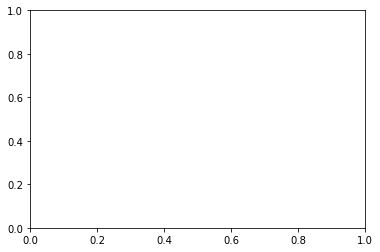

In [87]:
plt.plot(time, flux_system)
plt.xlabel("time [days]")
plt.ylabel("system flux");

In [39]:
planet.r = 0.33
system.show(t=np.linspace(0, 1, 50), window_pad=4, figsize=(8, 8))

Compiling `compute_rect_grid`... Done.
Compiling `compute_moll_grid`... Done.
Compiling `compute_ortho_grid`... Done.


# Generate Simulated Lightcurve with Exoplanet 

class exoplanet.orbits.KeplerianOrbit(period, a, t0, t_periastron,
incl, b, duration, ecc, omega, sin_omega, cos_omega, Omega, m_planet,
m_star, r_star, rho_star, ror, model)

In [113]:
def generate_lightcurve(period=3.456, u=[0.3,0.2],r=0.1,texp=0.02, b=0, m_star=1,r_star=1):
    """
    Function to generate lightcurve using Exoplanet

    Parameters
    ----------
    period : int, float
        Orbital period of planet
    u : list, array
        Quadratic Limb-darkening coefficients
    r : int, float
        Radius of planet in Solar radii
    texp : int, float
        Exposure time of lightcurve
    b : int, float
        Impact parameter
    m_star : int, float
        Mass of star in Solar masses
    r_star : int, float
        Radius of star in Solar radii
        

    Returns
    -------
    t : 1-D array
        Time array for the lightcurve
    lightcurve : 1-D array
        1-D flux array 
    """

    # The light curve calculation requires an orbit
    orbit = xo.orbits.KeplerianOrbit(period=period,b=b,m_star=m_star, r_star=r_star)

    # Compute a limb-darkened light curve using starry
    t = np.linspace(-0.1, 0.1, 1000)
    light_curve = (
        xo.LimbDarkLightCurve(*u)
        .get_light_curve(orbit=orbit, r=r, t=t, texp=texp)
        .eval()
    )
    # Note: the `eval` is needed because this is using Theano in
    # the background

    plt.plot(t, light_curve, color="C0", lw=2)
    plt.ylabel("relative flux")
    plt.xlabel("time [days]")
    _ = plt.xlim(t.min(), t.max())
    plt.show()
    plt.close()
    
    return t, light_curve

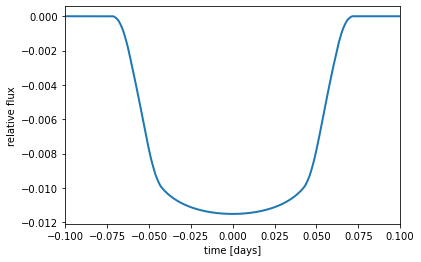

In [68]:
t,lc = generate_lightcurve()

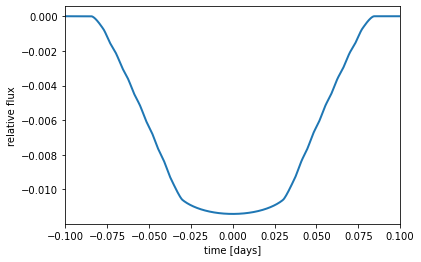

In [69]:
t,lc = generate_lightcurve(period=3.456, u=[0.3,0.2],r=0.1,texp=0.05)

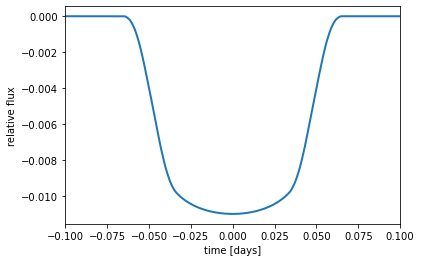

In [70]:
t,lc = generate_lightcurve(b=0.5)